# Predicting House Sales Price in King County, WA
### Final RMSE: $112,891 / Final R&sup2;: 0.89

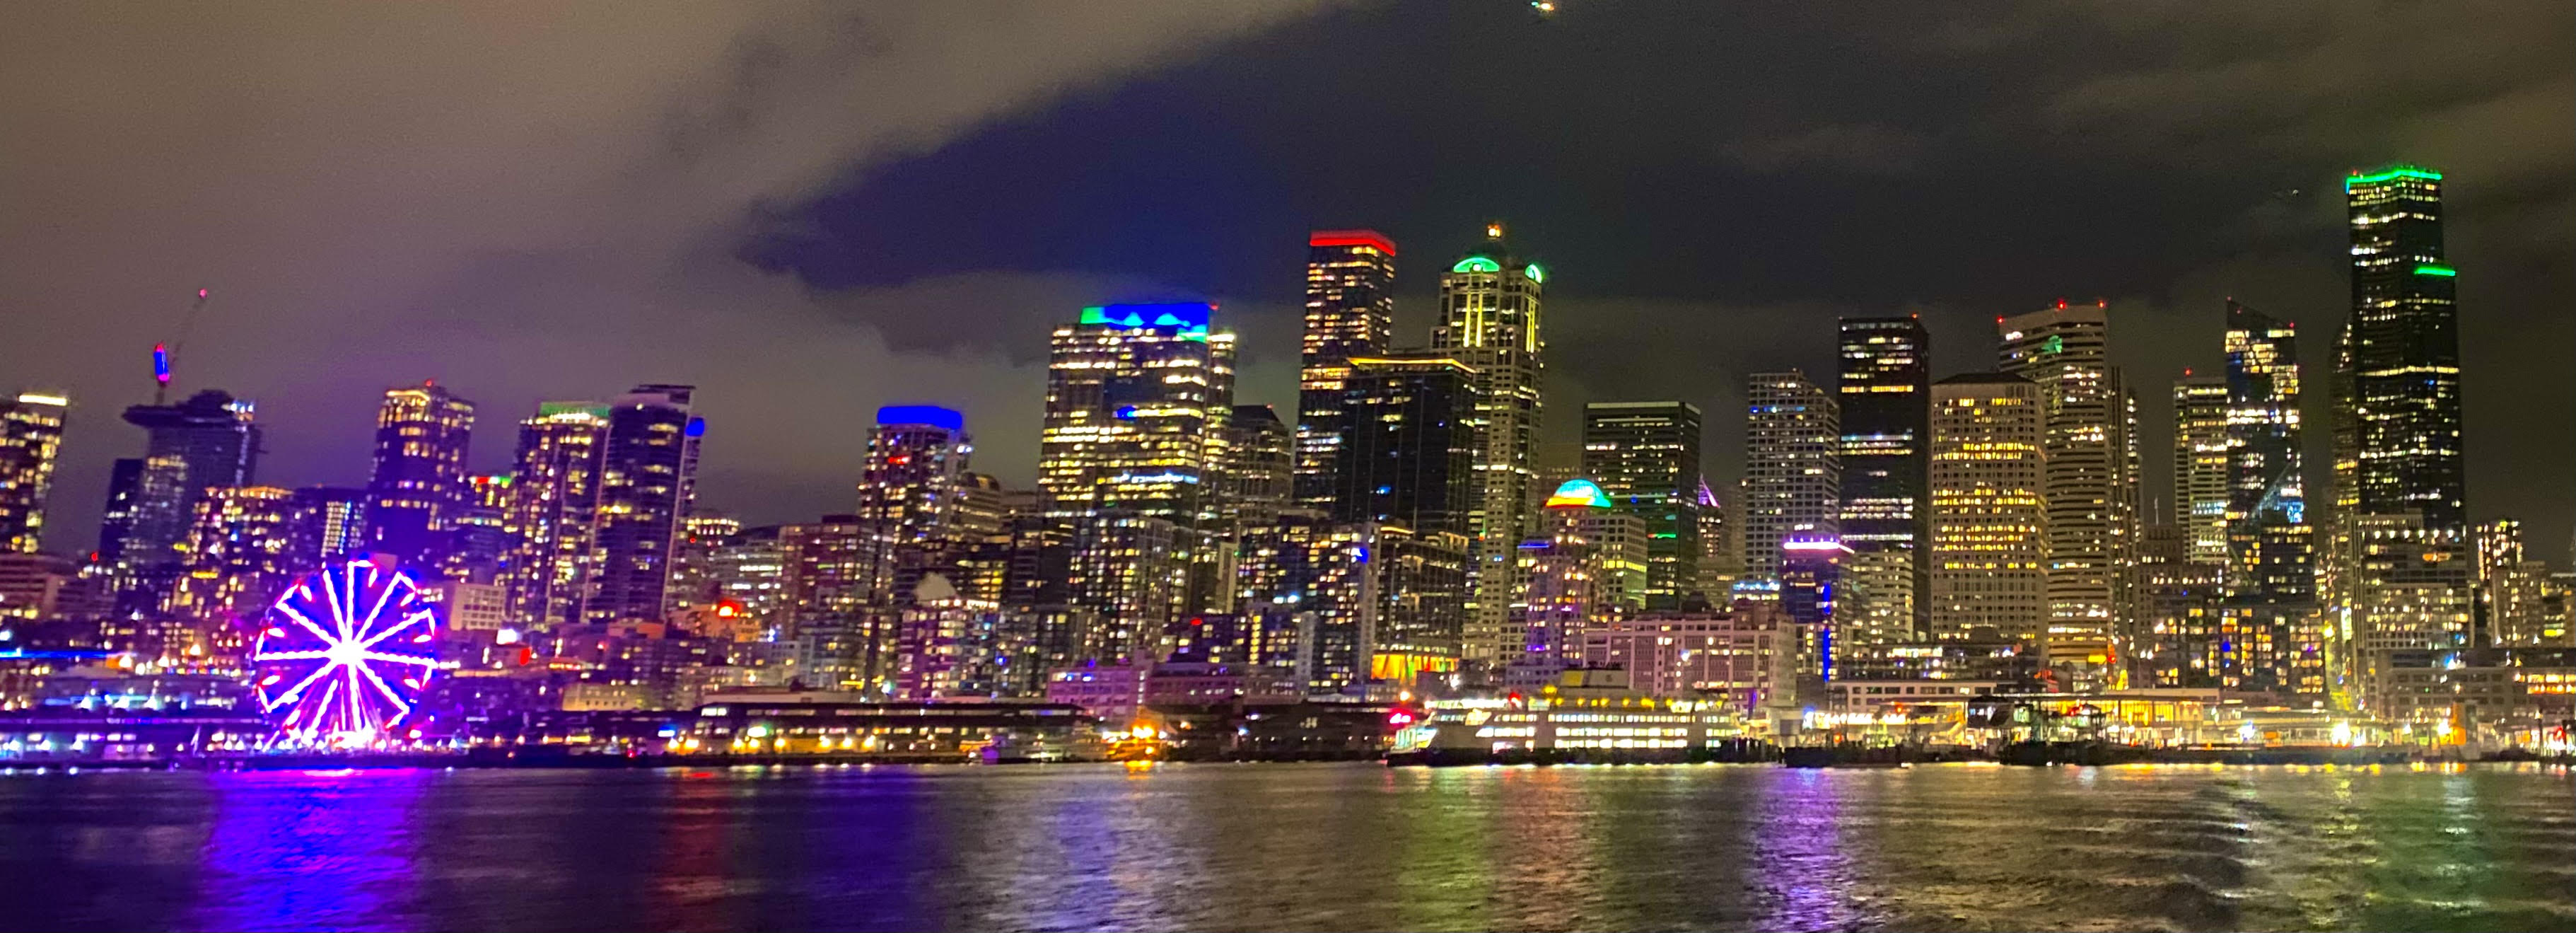

# Big Picture

Hello everyone! In this kernel, I will use a "[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)" dataset to build a model of housing prices in the county. I am going to only use __linear regression__ models (single, multiple, regularization) in this kernel and will not explore other algorithms like decision trees.

This dataset is from 7 years ago as of year 2024, so it is very possible that the model will not perform well with the current housing market. Still, this dataset is used by many practitioners and is great for practice. 

# Table of Contents <a id = '0'></a>

1. [Select a Performance Measure](#1)
2. [Import Modules & Read the Dataset](#2)
3. [Define Functions](#3)
4. [EDA](#4) <br>
   4.1. [Columns and Data Type](#4.1)<br>
   4.2. [Outliers](#4.2)<br>
   4.3. [Duplicates](#4.3)<br>
   4.4. [Distributions](#4.4)<br>
   4.4.1. [Histograms (continuous)](#4.4.1)<br>
   4.4.2. [Boxplots (discrete)](#4.4.2)<br>
5. [Create a Train Set and Test Set](#5)<br>
6. [EDA Part 2](#6)<br>
   6.1 [Visualize Geographical Data](#6.1)<br>
   6.2 [Correlation](#6.2)<br>
7. [Train, Compare, and Select a Model](#7)<br>
   7.1. [Simple Linear Regression](#7.1)<br>
   7.2. [Multiple Linear Regression (all original features)](#7.2)<br>
   7.3. [Multiple Linear Regression (all original features + "resale_within_1y?")](#7.3)<br>
   7.4. [Multiple Linear Regression (all original features + "resale_within_1y?" + binned age features)](#7.4)<br>
   7.5. [Multiple Linear Regression (zipcode as categorical)](#7.5)<br>
   7.6. [Multiple Linear Regression (location similarities w/ n_clusters = 5 & gamma = 1)](#7.6)<br>
   7.7. [Multiple Linear Regression (location similarities w/ n_cluster = 21 & gamma = 39)](#7.7)<br>
   7.8. [Multiple Linear Regression (location similarities w/ n_clusters = 20 & gamma = 40)](#7.8)<br>
   7.9. [Multiple Linear Regression (location similarities w/ n_clusters = 20 & gamma = 35)](#7.9)<br>
   7.10. [Multiple Linear Regression (root squared)](#7.10)<br>
   7.11. [Multiple Linear Regression (log-transformed a target variable)](#7.11)<br>
   7.12. [Ridge Regression](#7.12)<br>
   7.13. [Lasso Regression](#7.13)<br>
8. [Choose a Model](#8)<br>
9. [Evaluate a Model with Test Set](#9)<br>
10. [Build a Full-Pipeline](#10)<br>
11. [Final Result](#11)<br>
12. [Conclusion](#12)<br>

# 1. Select a Performance Measure <a id = 1></a>
[Return to Table of Contents](#0)

In this kernel, I am going to use the ___Root Mean Squared Error___ (__RMSE__) as a performance measure. It explains how much error the model typically makes in its predictions. It is important to note that RMSE penalizes larger errors more heavily than other performance measures like _Mean Absolute Error_, or MAE. 

I will also utilize ___R&sup2;___ to evaluate how well the independent variables in a regression model explain the variability observed in the dependent variables. It is a measure of fit, indicating the proportion of the total variation in the dependent variables that is captured by the model.

The goal in this kernel is to build a model that can __make accurate predictions on new, unseen data__. Therefore, I am not going to be overly concerned with the interpretation of the individual coefficients.

# 2. Import Modules & Read the Dataset <a id = 2></a>
[Return to Table of Contents](#0)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import randint
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/housesalesprediction/kc_house_data.csv


In [2]:
df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv', 
                 parse_dates = ['date'])

# 3. Define Functions <a id = 3></a>
[Return to Table of Contents](#0)

While the traditional R&sup2; measures the proportion of variance in the dependent variable explained by the independent variables, the ___Adjusted R&sup2;___ takes into account the number of predictors in the model and penalizes the model for including irrelevant predictors that do not contribute significantly to explaining the variation in the dependent variable. It provides a more realistic assessment of the model's fit, especially when comparing models with a different number of predictors.

In [3]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

The following custom transformer uses a KMeans clusterer in the fit() method to identify the main clusters based on "lat" and "long" features in the training data. It then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center.

This code is a modified version of the code provided in the book "[Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975)" by Aurélien Géron from O'Reilly.

In [4]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

I am going to store each model's score in an "__evaluation__" dataframe, so I can compare them easily.

In [5]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'RMSE (10 fold)': [],
                           'RMSE (cv)': [],
                           'R-squared (cv)':[],
                           'Adj. R-squared':[]}
                         )

evaluation

Empty DataFrame
Columns: [Model, Details, RMSE (10 fold), RMSE (cv), R-squared (cv), Adj. R-squared]
Index: []

# 4. EDA <a id = 4></a>
[Return to Table of Contents](#0)

Let's explore the data.

## 4.1. Columns and Data Type <a id = 4.1></a>
[Return to Table of Contents](#0)

The image below describes each column in the dataset. You can also find the same info from [this kaggle page](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion/82135#2634580).

![All Headers Explained](https://image.slidesharecdn.com/team6projectpaper-170912054146/75/predicting-king-county-house-prices-3-2048.jpg?cb=1665709875)

In [6]:
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

Notes from the information above:
- There is no null values in this dataset. All columns contain 21613 non-null values.
- The regression model does not accept a datatype of datetime. Some feature engineering is needed. 
- "price" will be used as a target variable "y".

In [8]:
df.describe()

id                           date         price  \
count  2.161300e+04                          21613  2.161300e+04   
mean   4.580302e+09  2014-10-29 04:38:01.959931648  5.400881e+05   
min    1.000102e+06            2014-05-02 00:00:00  7.500000e+04   
25%    2.123049e+09            2014-07-22 00:00:00  3.219500e+05   
50%    3.904930e+09            2014-10-16 00:00:00  4.500000e+05   
75%    7.308900e+09            2015-02-17 00:00:00  6.450000e+05   
max    9.900000e+09            2015-05-27 00:00:00  7.700000e+06   
std    2.876566e+09                            NaN  3.671272e+05   

           bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  21613.000000  21613.000000  21613.000000  2.161300e+04  21613.000000   
mean       3.370842      2.114757   2079.899736  1.510697e+04      1.494309   
min        0.000000      0.000000    290.000000  5.200000e+02      1.000000   
25%        3.000000      1.750000   1427.000000  5.040000e+03      1.000000   
50%        3.000000      2.250000   1910.000000  7.618000e+03      1.500000   
75%        4.000000      2.500000   2550.000000  1.068800e+04      2.000000   
max       33.000000      8.000000  13540.000000  1.651359e+06      3.500000   
std        0.930062      0.770163    918.440897  4.142051e+04      0.539989   

         waterfront          view  ...         grade    sqft_above  \
count  21613.000000  21613.000000  ...  21613.000000  21613.000000   
mean       0.007542      0.234303  ...      7.656873   1788.390691   
min        0.000000      0.000000  ...      1.000000    290.000000   
25%        0.000000      0.000000  ...      7.000000   1190.000000   
50%        0.000000      0.000000  ...      7.000000   1560.000000   
75%        0.000000      0.000000  ...      8.000000   2210.000000   
max        1.000000      4.000000  ...     13.000000   9410.000000   
std        0.086517      0.766318  ...      1.175459    828.090978   

       sqft_basement      yr_built  yr_renovated       zipcode           lat  \
count   21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean      291.509045   1971.005136     84.402258  98077.939805     47.560053   
min         0.000000   1900.000000      0.000000  98001.000000     47.155900   
25%         0.000000   1951.000000      0.000000  98033.000000     47.471000   
50%         0.000000   1975.000000      0.000000  98065.000000     47.571800   
75%       560.000000   1997.000000      0.000000  98118.000000     47.678000   
max      4820.000000   2015.000000   2015.000000  98199.000000     47.777600   
std       442.575043     29.373411    401.679240     53.505026      0.138564   

               long  sqft_living15     sqft_lot15  
count  21613.000000   21613.000000   21613.000000  
mean    -122.213896    1986.552492   12768.455652  
min     -122.519000     399.000000     651.000000  
25%     -122.328000    1490.000000    5100.000000  
50%     -122.230000    1840.000000    7620.000000  
75%     -122.125000    2360.000000   10083.000000  
max     -121.315000    6210.000000  871200.000000  
std        0.140828     685.391304   27304.179631  

[8 rows x 21 columns]

Notes from the table above:
- "price" is ranging from __75,000 - 7,700,000__ with a median value of __450,000__.
- __The scale of each independent variable is significantly different__. ML algorithms do not usually perform well when the input numerical attributes have significantly different scales. Without any scaling, most models will be biased toward ignoring large-scale variables and focusing more on small-scale variables.

Let's plot a target variable to get a feel of the data.

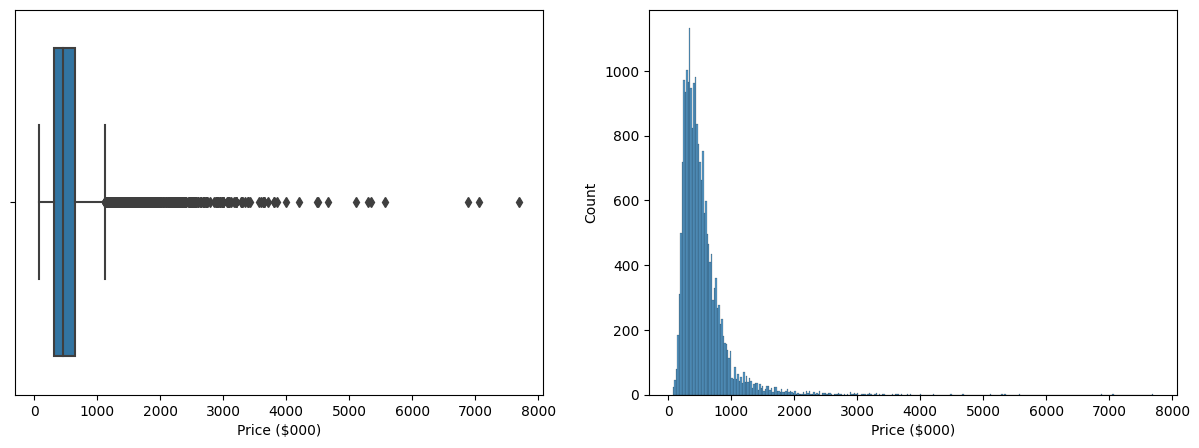

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(data = df,
            x = df['price'] / 1000,
            ax = axes[0])

axes[0].set_xlabel('Price ($000)')

sns.histplot(data = df,
             x = df['price'] / 1000,
             ax = axes[1])

axes[1].set_xlabel("Price ($000)");

It is clear that the "price" data is __skewed right__: they extend much farther to the right of the median than to the left. We should probably try transforming a target variable to have more bell-shaped distribution. Let's take a closer look at the outliers that live in the farther right. 

## 4.2. Outliers <a id = 4.2></a>
[Return to Table of Contents](#0)

In [10]:
print(f'Min: {df.price.min()}')
print(f'mean: {df.price.mean()}')
print(f'median: {df.price.median()}')
print(f'IQR: {np.percentile(df.price.sort_values(), 75) - np.percentile(df.price.sort_values(), 25)}') 
print(f'Max: {df.price.max()}')

Min: 75000.0
mean: 540088.1417665294
median: 450000.0
IQR: 323050.0
Max: 7700000.0


In [11]:
Q1 = np.percentile(df.price.sort_values(), 25)
Q3 = np.percentile(df.price.sort_values(), 75)
IQR = np.percentile(df.price.sort_values(), 75) - np.percentile(df.price.sort_values(), 25)
mask = (df['price'] < Q1 - IQR * 1.5) | (df['price'] > Q3 + IQR * 1.5)
                   
df.loc[mask].sort_values(by = 'id', ascending = False)

id       date      price  bedrooms  bathrooms  sqft_living  \
11924  9831200520 2014-10-06  1443920.0         4       3.00         3720   
4811   9831200500 2015-03-04  2479000.0         5       3.75         6810   
19667  9831200172 2015-02-27  1450000.0         4       3.50         2860   
19758  9831200159 2014-08-06  2250000.0         3       3.25         3890   
18655  9829201020 2014-11-18  1388000.0         3       1.25         2400   
...           ...        ...        ...       ...        ...          ...   
15912    98000130 2015-03-24  1425000.0         4       5.00         4630   
17980    46100504 2014-06-17  2027000.0         4       3.75         4100   
11673    46100350 2014-06-30  1730000.0         5       3.50         5000   
216      46100204 2015-02-21  1505000.0         5       3.00         3300   
4743     31000165 2014-09-11  1490000.0         5       3.50         3620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
11924      5000     2.5           0     0  ...      9        2720   
4811       7500     2.5           0     0  ...     13        6110   
19667      2199     3.0           0     0  ...     10        2860   
19758      3452     2.0           0     0  ...     12        2890   
18655      6653     3.0           0     2  ...     11        2400   
...         ...     ...         ...   ...  ...    ...         ...   
15912     24054     2.0           0     3  ...     11        4630   
17980     22798     1.5           0     3  ...     11        2540   
11673     26540     2.0           0     3  ...     10        3410   
216       33474     1.0           0     3  ...      9        1870   
4743       7821     2.0           0     2  ...     10        2790   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
11924           1000      1905             0    98102  47.6282 -122.322   
4811             700      1922             0    98102  47.6285 -122.322   
19667              0      2013             0    98102  47.6262 -122.323   
19758           1000      2006             0    98102  47.6260 -122.323   
18655              0      1992             0    98122  47.6019 -122.290   
...              ...       ...           ...      ...      ...      ...   
15912              0      2005             0    98075  47.5870 -121.966   
17980           1560      1934          1979    98040  47.5648 -122.210   
11673           1590      2008             0    98040  47.5665 -122.210   
216             1430      1957          1991    98040  47.5673 -122.210   
4743             830      1958          2010    98040  47.5738 -122.215   

       sqft_living15  sqft_lot15  
11924           2610        5000  
4811            2660        7500  
19667           1990        1378  
19758           2860        2199  
18655           1910        6653  
...              ...         ...  
15912           4630       17584  
17980           3880       18730  
11673           3360       17398  
216             3836       20953  
4743            2690        9757  

[1146 rows x 21 columns]

About 5% of data is considered outliers (1146/21613). There are multiple options to handle outliers, including removing them, keeping them as is, etc. For this dataset, I will keep them as is because __high-priced houses may not necessarily be outliers; they could be luxury properties or homes with exceptional features__.

## 4.3. Duplicates <a id = 4.3></a>
[Return to Table of Contents](#0)

The "id" column contains duplicates. 

In [12]:
df[df['id'].duplicated(keep = False)].sort_values(['id', 'date'])

id       date     price  bedrooms  bathrooms  sqft_living  \
2496      1000102 2014-09-16  280000.0         6       3.00         2400   
2497      1000102 2015-04-22  300000.0         6       3.00         2400   
16814     7200179 2014-10-16  150000.0         2       1.00          840   
16815     7200179 2015-04-24  175000.0         2       1.00          840   
11433   109200390 2014-08-20  245000.0         3       1.75         1480   
...           ...        ...       ...       ...        ...          ...   
6346   9828200460 2015-01-06  430000.0         2       1.00          700   
15199  9834200305 2014-07-16  350000.0         3       1.00         1790   
15200  9834200305 2015-02-10  615000.0         3       1.00         1790   
1085   9834200885 2014-07-17  360000.0         4       2.50         2080   
1086   9834200885 2015-04-20  550000.0         4       2.50         2080   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2496       9373     2.0           0     0  ...      7        2400   
2497       9373     2.0           0     0  ...      7        2400   
16814     12750     1.0           0     0  ...      6         840   
16815     12750     1.0           0     0  ...      6         840   
11433      3900     1.0           0     0  ...      7        1480   
...         ...     ...         ...   ...  ...    ...         ...   
6346       4800     1.0           0     0  ...      7         700   
15199      3876     1.5           0     0  ...      7        1090   
15200      3876     1.5           0     0  ...      7        1090   
1085       4080     1.0           0     0  ...      7        1040   
1086       4080     1.0           0     0  ...      7        1040   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2496               0      1991             0    98002  47.3262 -122.214   
2497               0      1991             0    98002  47.3262 -122.214   
16814              0      1925             0    98055  47.4840 -122.211   
16815              0      1925             0    98055  47.4840 -122.211   
11433              0      1980             0    98023  47.2977 -122.367   
...              ...       ...           ...      ...      ...      ...   
6346               0      1922             0    98122  47.6147 -122.300   
15199            700      1904             0    98144  47.5750 -122.288   
15200            700      1904             0    98144  47.5750 -122.288   
1085            1040      1962             0    98144  47.5720 -122.290   
1086            1040      1962             0    98144  47.5720 -122.290   

       sqft_living15  sqft_lot15  
2496            2060        7316  
2497            2060        7316  
16814           1480        6969  
16815           1480        6969  
11433           1830        6956  
...              ...         ...  
6346            1440        4800  
15199           1360        4080  
15200           1360        4080  
1085            1340        4080  
1086            1340        4080  

[353 rows x 21 columns]

Notes from the table above:
- The second sale is almost always sold __at the higher price__.
- The second sale is almost always sold __within 1 year since the first sale__.

I believe it is reasonable to hypothesize that many of these are examples of "__house flipping__," where individuals or entities buy properties, make improvements, and then sell them at a higher price. Since the second sale is consistently higher and occurs relatively soon after the first, it supports the idea of property enhancement before resale.

Incorporating this assumption into our regression model could potentially improve its predictive capabilities, __as it accounts for the possibility of different types of transactions for the same property__.

## 4.4. Distributions <a id = 4.4></a>
[Return to Table of Contents](#0)

Let's plot each independent variable and see if there are any patterns.

### 4.4.1. Histograms (continuous) <a id = 4.4.1></a>

[Return to Table of Contents](#0)

For continuous variables, I prefer to use histograms.

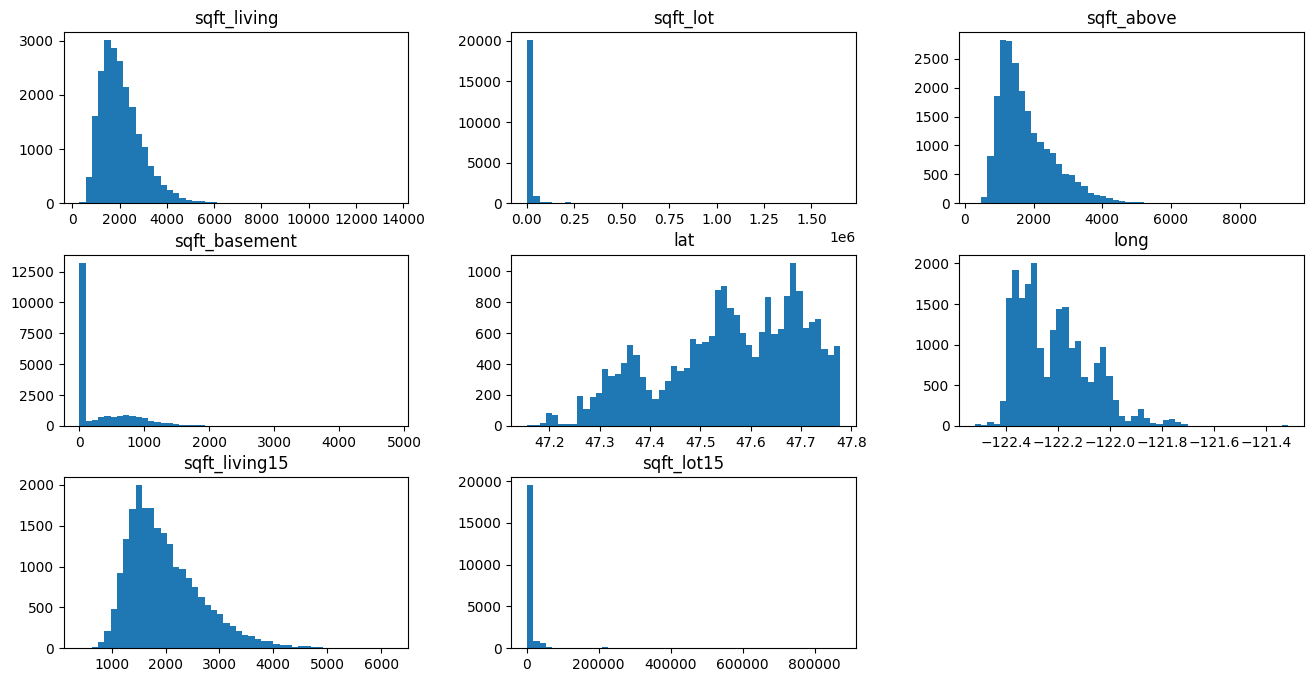

In [13]:
features_cont = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

df[features_cont].hist(bins = 50, figsize = (16, 8), grid = False);

Notes from the plots above:
- All "sqft" features are skewed right (similar to the distribution of "price").  
- When a feature's distribution has a heavy tail, feature scaling (both min-max scaling and standardization) will squash most values into a small range. ML models generally do not like this. Therefore, before scaling the feature, we should first transform it to shrink the heavy tail, and, if possible, to make the distribution roughly symmetrical. 
- A common way to do this for positive features with a heavy tail to the right is __to replace the feature with its square root__ (or raise the feature to a power between 0 and 1). If the feature has a really long and heavy tail, then replacing the feature with its logarithm may help.

### 4.4.2. Boxplots (discrete) <a id = 4.4.2></a>
[Return to Table of Contents](#0)

For discrete variables, I prefer to use boxplots.

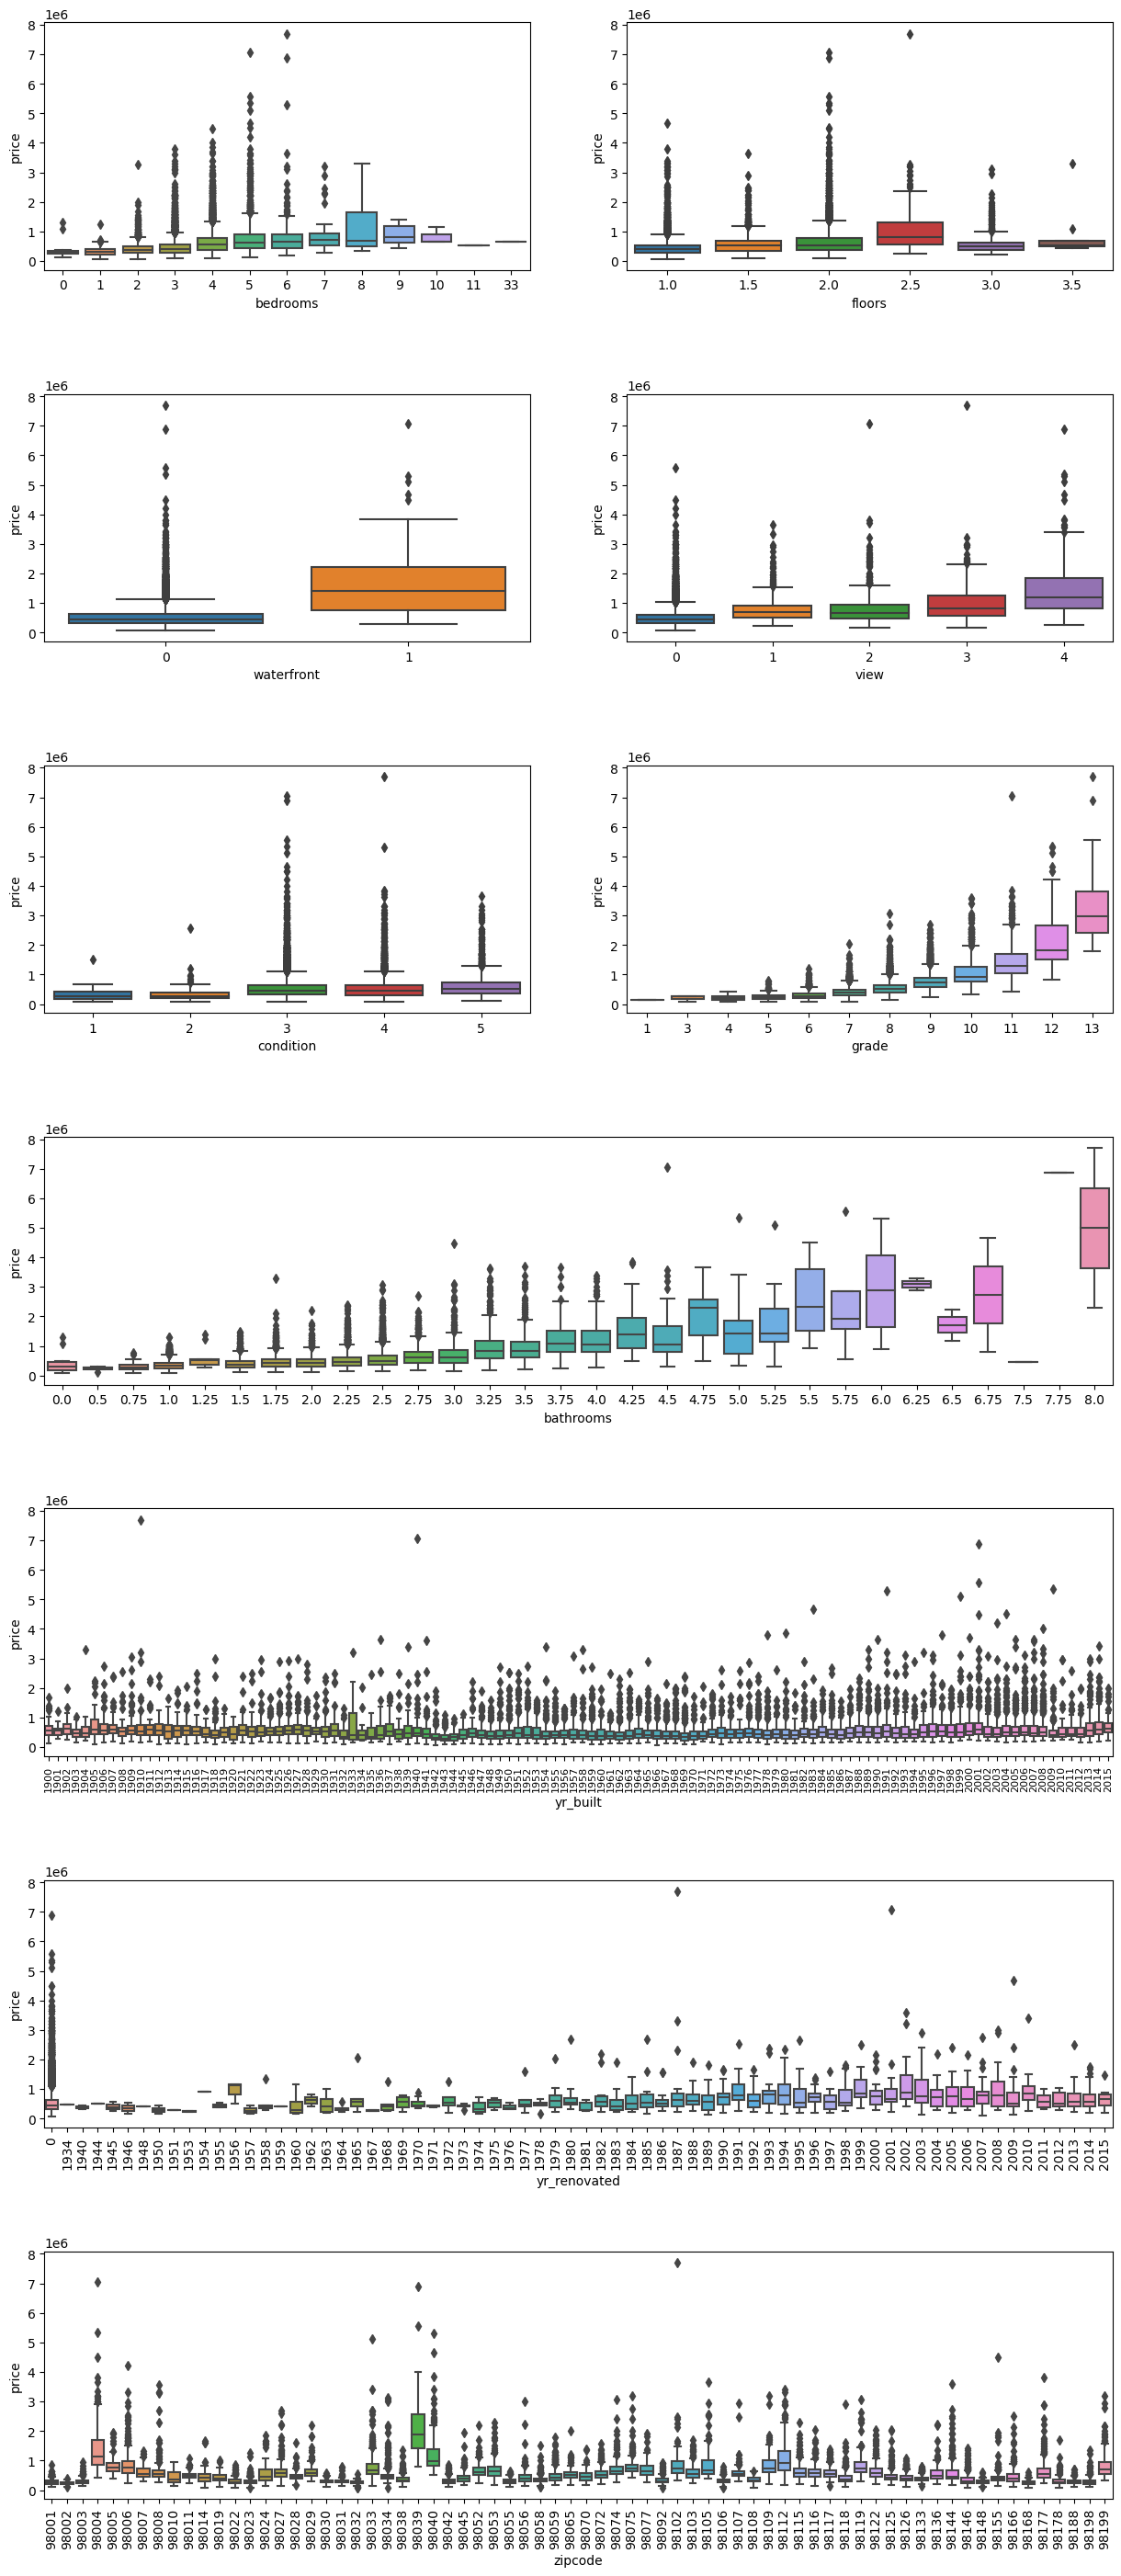

In [14]:
fig = plt.figure(figsize = (15, 35))
gs = gridspec.GridSpec(ncols = 2, nrows = 7, hspace = 0.5)

ax1 = fig.add_subplot(gs[0, 0:1])
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=ax1)

ax2 = fig.add_subplot(gs[0, 1:2])
sns.boxplot(x=df['floors'],y=df['price'], ax=ax2)

ax3 = fig.add_subplot(gs[1, 0:1])
sns.boxplot(x=df['waterfront'],y=df['price'], ax=ax3)

ax4 = fig.add_subplot(gs[1, 1:2])
sns.boxplot(x=df['view'],y=df['price'], ax=ax4)

ax5 = fig.add_subplot(gs[2, 0:1])
sns.boxplot(x=df['condition'],y=df['price'], ax=ax5)

ax6 = fig.add_subplot(gs[2, 1:2])
sns.boxplot(x=df['grade'],y=df['price'], ax=ax6)

ax7 = fig.add_subplot(gs[3, 0:2])
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=ax7)

ax8 = fig.add_subplot(gs[4, 0:2])
sns.boxplot(x=df['yr_built'],y=df['price'], ax=ax8)
plt.xticks(rotation=90, fontsize = 8);

ax9 = fig.add_subplot(gs[5, 0:2])
sns.boxplot(x=df['yr_renovated'],y=df['price'], ax=ax9)
plt.xticks(rotation=90);

ax10 = fig.add_subplot(gs[6, 0:2])
sns.boxplot(x=df['zipcode'],y=df['price'], ax=ax10)
plt.xticks(rotation=90);

Notes from the plots above:
- "bedrooms", "view", "grade", and "bathrooms" share a similar pattern: the more the number increases, the more the variation.
- Houses that are overlooking the "waterfront" tend to be more expensive.
- "yr_built" and "yr_renovation" features seem to be not very useful by themselves. Getting the __age of each house__ ("date" - "yr_built"("yr_renovated")) will probably be more useful.

Later, I will create age features for "yr_built" and "yr_renovated" to calculate the years since a house is built/renovated. I will also discretize these ages to reduce the effects of noise or the impact of outliers in the data. 

# 5. Create a Train Set and Test Set <a id = 5></a>
[Return to Table of Contents](#0)

Before going more in depth, let's split the data and put the test set aside to avoid estimates from becoming too optimistic. 

My educated guess is that among the features in the dataset, "sqft_living" is the most important variable to predict housing prices. I want to ensure that the test set is representative of the various categories of "sqft_living" in the whole dataset. To accomplish this, I am going to use ___stratified sampling___: the "sqft_living" is divided into subgroups called _strata_, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall sqft_living. 

Since the sqft_living is a continuous numerical attribute, let's first create a sqft_living category attribute. I am going to create 4 subgroups.

In [15]:
df['sqft_living_cat'] = pd.cut(df['sqft_living'],
                                   bins = [0, 2000, 4000, 6000, np.inf],
                                   labels = [">= 2000", ">= 4000", ">= 6000", "> 6000"])

<Axes: xlabel='sqft_living_cat'>

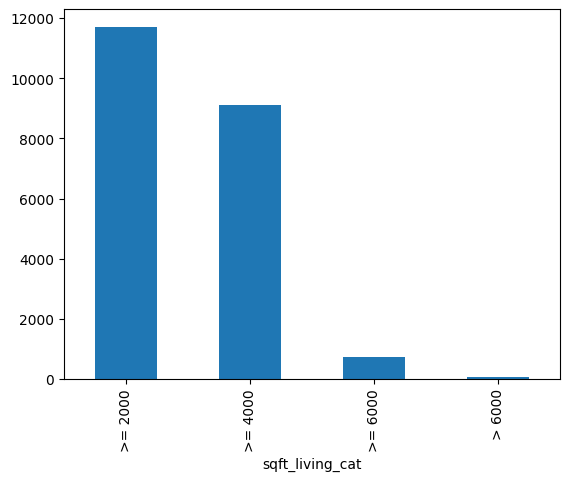

In [16]:
df['sqft_living_cat'].value_counts().sort_index().plot.bar()

Now, let's split the data using train_test_split() function with the stratify argument.

In [17]:
strat_tr, strat_test = train_test_split(df, 
                                        test_size = 0.2, 
                                        stratify = df['sqft_living_cat'], 
                                        random_state = 42)

Let's check if the split worked as expected:

In [18]:
def sqft_living_cat_proportions(data):
    return data["sqft_living_cat"].value_counts() / len(data)

#purely random sampling
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": sqft_living_cat_proportions(df),
    "Stratified %": sqft_living_cat_proportions(strat_test),
    "Random %": sqft_living_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Sqft_Living Category"

compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)

compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)

(compare_props * 100).round(2)

Overall %  Stratified %  Random %  Strat. Error %  \
Sqft_Living Category                                                      
>= 2000                   54.19         54.20     53.53            0.02   
>= 4000                   42.19         42.19     42.33            0.01   
>= 6000                    3.31          3.31      3.68           -0.01   
> 6000                     0.31          0.30      0.46           -4.42   

                      Rand. Error %  
Sqft_Living Category                 
>= 2000                       -1.22  
>= 4000                        0.34  
>= 6000                       11.18  
> 6000                        47.05

The test set generated using stratified sampling has "sqft_living" category proportions almost identical to those in the full dataset, while the test set generated using purely random sampling is skewed. I will drop the "sqft_living_cat" column since I will not use it anymore. 

In [19]:
for set_ in (strat_tr, strat_test):
    set_.drop(['sqft_living_cat'], axis = 1, inplace = True)

Later, I will split the training set once again into a smaller training set and a cross validation (cv) set. This way I can use the training set to train the model, the validation set to tune hyperparameters and avoid overfitting, and the test set to assess the model's generalization to unseen data.

Moving forward, we will only use the training set to explore the data. Since I am going to experiment with various transformations, I am going to make a copy of the original so I can revert to it afterwards.

In [20]:
housing = strat_tr.copy()

# 6. EDA Part 2 <a id = 6></a>
[Return to Table of Contents](#0)

Now, let's further explore our training data.

## 6.1. Visualize Geographical Data <a id = 6.1></a>
[Return to Table of Contents](#0)

The dataset has "lat" and "long" features. Let's plot a scatterplot.

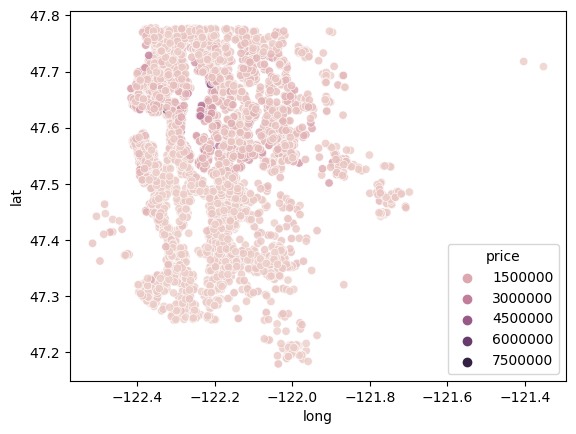

In [21]:
sns.scatterplot(data = housing.sample(5000),
                x = 'long',
                y = 'lat',
                hue = 'price',
                alpha = 0.8
               );

It seems that the areas around Lake Washington tend to be more expensive than other areas in King County. There is Seattle on the west side of the Lake. [This website](https://zerodown.com/rankings/king-county--wa/expensive) lists top 10 most expensive cities in King County, such as Kirkland, Yarrow Point, Hunts Point, Beaux Arts Village, etc., and the majority of them are lining the east side of the Lake.

## 6.2. Correlation <a id = 6.2></a>
[Return to Table of Contents](#0)

Since the data is not too large, let's plot a correlation matrix to see how much each variable correlates to other variables.

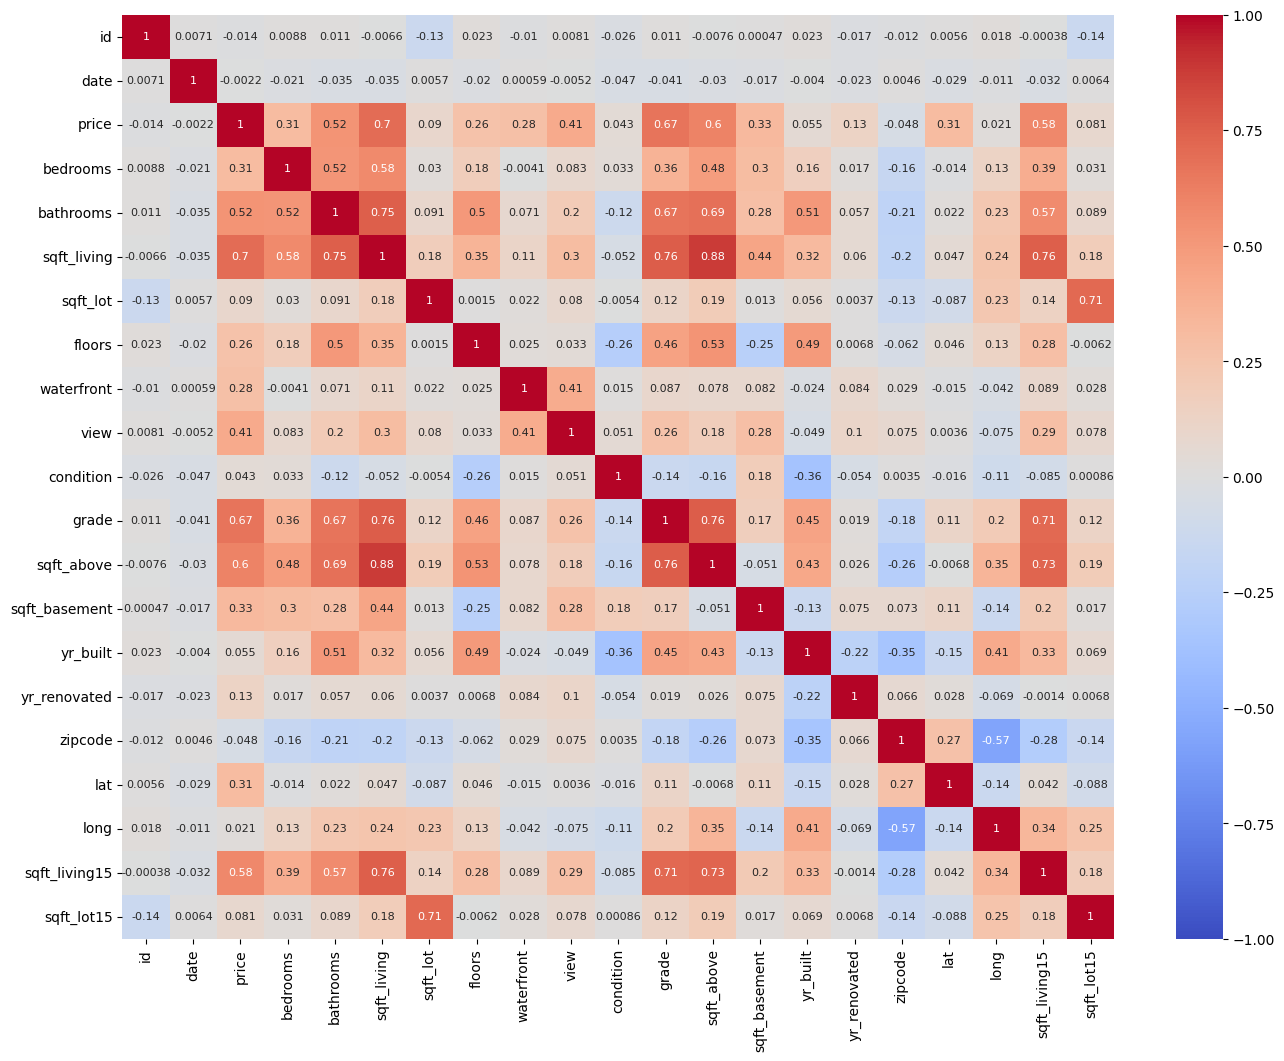

In [22]:
plt.figure(figsize = (16, 12))

sns.heatmap(housing.corr(), 
            vmin = -1, vmax = 1, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws={"size":8});

Notes from the correlation matrix above:
- As I guessed earlier, "sqft_living" has the highest correlation to "price" with 0.7
- Many independent variables are correlated with each other (sqft_living vs sqft_above, sqft_living vs grade, sqft_living vs bathrooms, etc.). This introduces a risk of multicollinearlity.
- There is a small positive correlation between "lat" and "price" with 0.31, indicating that prices tend to slighly go up as you go north.
- Correlation between "yr_built"/"yr_renovated" and "price" is very low. As mentioned earlier, creating a new feature for age since a house is built/renovated might be more useful. 

We can also use seaborn's pairplot() function to plot every numerical variable against every other numerical variable. This is computationally more expensive as it plots (number of numerical variables&sup2;) plots. In our case, we are going to get 361 (19&sup2;) plots or 190 plots if you specify _corner = True_.

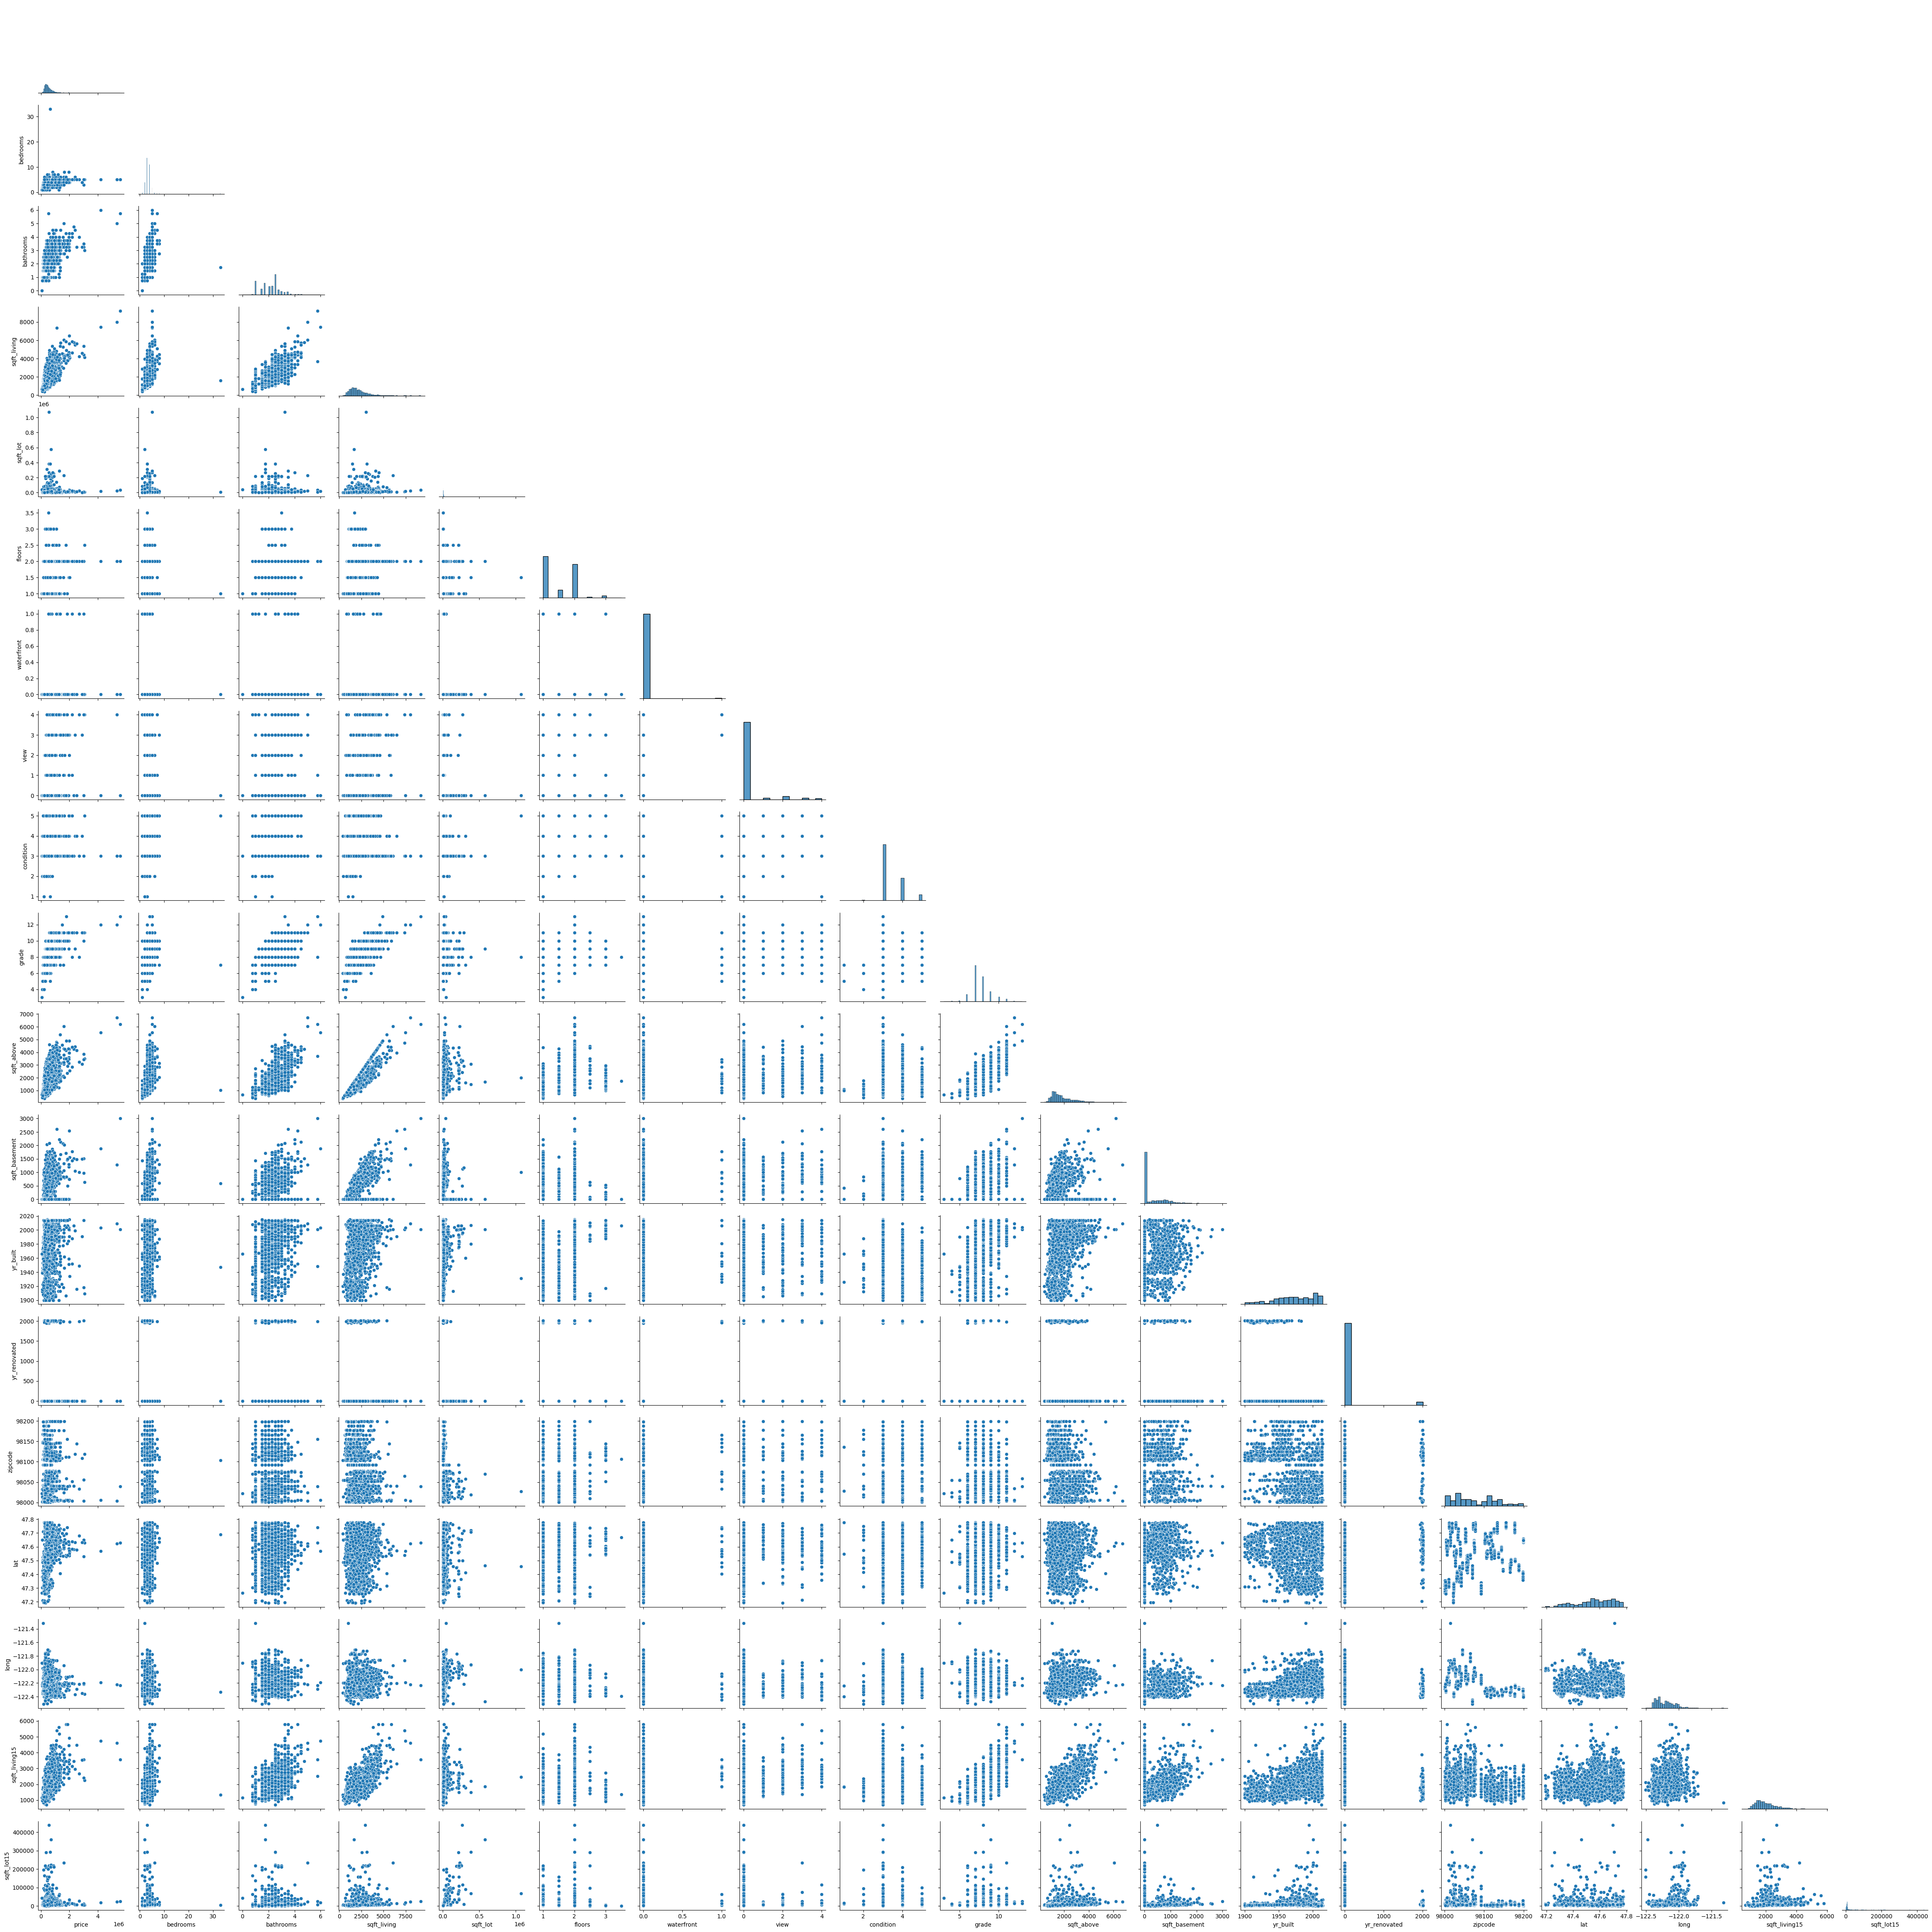

In [23]:
num_features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                'floors', 'waterfront', 'view', 'condition', 'grade', 
                'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated','zipcode', 
                'lat', 'long', 'sqft_living15', 'sqft_lot15']

sns.pairplot(data = housing[num_features].sample(2000), corner = True);

It seems like the most promising predictor is "sqft_living". Let's zoom in on their scatterplot.

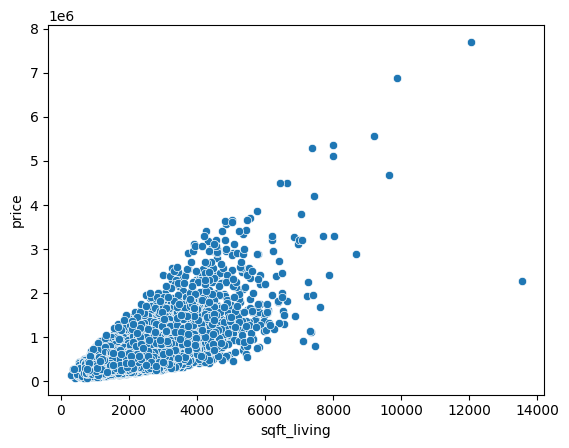

In [24]:
sns.scatterplot(housing,
                x = 'sqft_living',
                y = 'price');

It clearly shows ___heteroscedasticity___, where the variability of the residuals is not constant across all levels of the independent variable (as "sqft_living" increases, the variation in "price" becomes larger). When heteroscedasticity is observed, it is usually better to apply transformations to the variables involved, such as taking the logarithm or square root to stabilize the variance. Later, I will apply those transformations and compare with other models with no transormatinos to the variables with heteroscedasticity. 

The chart below is a little sneak peek of the relationship between square root of "sqft-living" and log of "price". It shows a clean linear relationship, and the model will most likely perform better with this. 

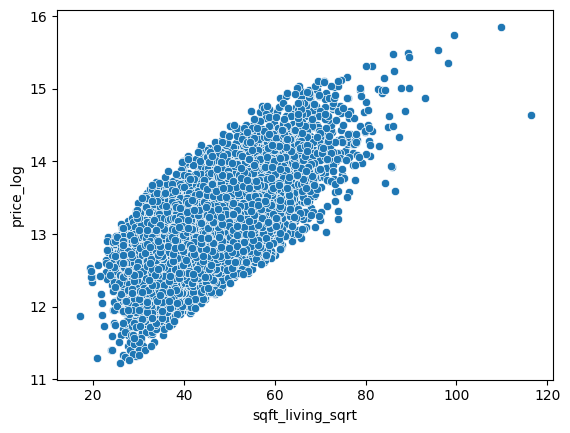

In [25]:
sns.scatterplot(housing,
                x = np.sqrt(housing['sqft_living']),
                y = np.log(housing['price']))

plt.xlabel('sqft_living_sqrt')
plt.ylabel('price_log');

## 6.3. Create New Features <a id = 6.3></a>
[Return to Table of Contents](#0)

Earlier, we found that there are duplicates in the "id" column and they share the similar pattern:
- The second sale is almost always sold __at the higher price__.
- The second sale is almost always sold __within 1 year since the first sale__.

Let's create a new feature "resale_within_1y?" that returns 1 if it is a second sale and occurred within 1 year since the first sale, otherwise 0.

In [26]:
housing = housing.sort_values(['id', 'date'], ascending = [True, True])
strat_test = strat_test.sort_values(['id', 'date'], ascending = [True, True])

housing['resale_within_1y?'] = np.where(housing.groupby('id')['date'].diff() <= pd.Timedelta(days=365), 1, 0)
strat_test['resale_within_1y?'] = np.where(strat_test.groupby('id')['date'].diff() <= pd.Timedelta(days=365), 1, 0)

housing.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
2496  1000102 2014-09-16  280000.0         6       3.00         2400   
2497  1000102 2015-04-22  300000.0         6       3.00         2400   
6735  1200019 2014-05-08  647500.0         4       1.75         2060   
8809  2800031 2015-04-01  235000.0         3       1.00         1430   
3557  3600057 2015-03-19  402500.0         4       2.00         1650   

      sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
2496      9373     2.0           0     0  ...        2400              0   
2497      9373     2.0           0     0  ...        2400              0   
6735     26036     1.0           0     0  ...        1160            900   
8809      7599     1.5           0     0  ...        1010            420   
3557      3504     1.0           0     0  ...         760            890   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
2496      1991             0    98002  47.3262 -122.214           2060   
2497      1991             0    98002  47.3262 -122.214           2060   
6735      1947             0    98166  47.4444 -122.351           2590   
8809      1930             0    98168  47.4783 -122.265           1290   
3557      1951          2013    98144  47.5803 -122.294           1480   

      sqft_lot15  resale_within_1y?  
2496        7316                  0  
2497        7316                  1  
6735       21891                  0  
8809       10320                  0  
3557        3504                  0  

[5 rows x 22 columns]

<Axes: xlabel='resale_within_1y?', ylabel='price'>

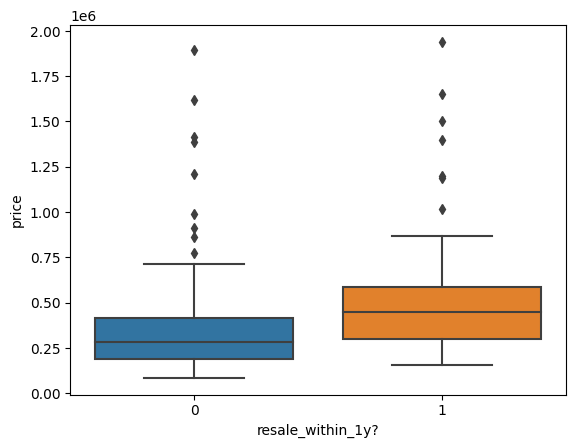

In [27]:
sns.boxplot(housing[housing['id'].duplicated(keep = False)],
            x = 'resale_within_1y?',
            y = 'price')

The boxplot above shows that the second sale tends to be more expensive than the first sale.

We also found that "yr_built" and "yr_renovated" might not be useful by themselves. Let's compute age of years since a house is built/renovated and then backet them into subgroups. For "yr_renovated", it returns 0 if a house was not renovated. To differentiate houses that weren't renovated and houses renovated within 1 year (age_rnv = 0), I am going to label houses that weren't renovated as -1.

In [28]:
# calculate age
housing['age_built'] = (housing['date'].astype('string').str[:4].astype(int) - housing['yr_built'])
strat_test['age_built'] = (strat_test['date'].astype('string').str[:4].astype(int) - strat_test['yr_built'])

housing['age_rnv'] = np.where(housing['yr_renovated'] == 0, 
                             -1, 
                             housing['date'].astype('string').str[:4].astype(int) - housing['yr_renovated'])

strat_test['age_rnv'] = np.where(strat_test['yr_renovated'] == 0, 
                             -1, 
                             strat_test['date'].astype('string').str[:4].astype(int) - strat_test['yr_renovated'])


# binning age_built into 8 groups
bins = [-2,0,5,10,25,50,75,100,np.inf]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']

housing['age_built_binned'] = pd.cut(housing['age_built'], 
                                    bins=bins, 
                                    labels=labels)

strat_test['age_built_binned'] = pd.cut(strat_test['age_built'], 
                                    bins=bins, 
                                    labels=labels)

# binning age_rnv into 6 groups
bins = [-2,-1,5,15,30,50, np.inf]
labels = ['-1','0-5','6-15','16-30','31-50','>50']

housing['age_rnv_binned'] = pd.cut(housing['age_rnv'], 
                                  bins=bins, 
                                  labels=labels)

strat_test['age_rnv_binned'] = pd.cut(strat_test['age_rnv'], 
                                  bins=bins, 
                                  labels=labels)

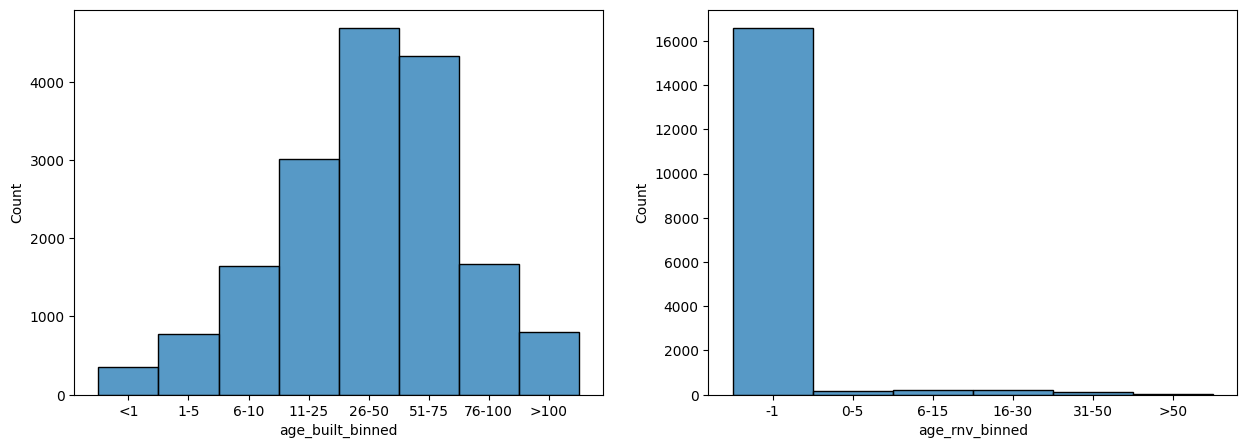

In [29]:
features_binned = ['age_built_binned', 'age_rnv_binned']

fig, ax = plt.subplots(1, 2, figsize = (15,5))

sns.histplot(housing, x = 'age_built_binned', ax = ax[0])
sns.histplot(housing, x = 'age_rnv_binned', ax = ax[1]);

It looks like "sqft_living" is calculated __by adding "sqft_above" and "sqft_basement"__, so it makes sense that "sqft_above" and "sqft_basement" is highly correlated with "sqft_living". Some houses do not have basement, meaning that "sqft_living" and "sqft_above" for those houses are same. In fact, "sqft_above" has very high correlation with "price" too. Using all these three variables in a model may introduce a risk of __multicollinearlity__ and can lead to instability in coefficient estimates and make it challenging to assess the individual contributions of each variable. 

There are multiple options to handle multicollinearlity. This time, I am not focusing much on coefficient estimates of each variable, so I will leave it as is.

# 7. Train, Compare, and Select a Model <a id = 7></a>
[Return to Table of Contents](#0)

Now, let's experiment with regression models and compare each model. I will continue to use the "housing" DataFrame. As mentioned earlier, I am going to split the training data again into a training set and a cross validation set. The data is not too large, so I am also going to utilize a 10-Fold Cross Validation method.

In [30]:
train, cv = train_test_split(housing, test_size = 0.25, random_state = 42)

In [31]:
X_tr = train.drop('price', axis = 1)
y_tr = train['price']
X_cv = cv.drop('price', axis = 1)
y_cv = cv['price']
X_test = strat_test.drop('price', axis = 1)
y_test = strat_test['price']

## 7.1. Simple Linear Regression <a id = 7.1></a>
[Return to Table of Contents](#0)

Since the "sqft_living" variable has the highest correlation with "price," let's train a simple linear regression model using "sqft_living" as a single predictor to see how it performs. 

In [32]:
model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[['sqft_living']],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))


model.fit(X_tr[['sqft_living']], y_tr)

pred = model.predict(X_cv[['sqft_living']])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[['sqft_living']], y_cv), '.3f'))

print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')

RMSE (10 fold): 260016.142
RMSE (cv): 274396.995
R2: 0.515


In [33]:
data = ['Simple Linear Regression','"sqft_living" as a single feature', rmse_10f, rmse , r2, '-']

evaluation.loc[0] = data
evaluation

Model                            Details  \
0  Simple Linear Regression  "sqft_living" as a single feature   

   RMSE (10 fold)   RMSE (cv)  R-squared (cv) Adj. R-squared  
0      260016.142  274396.995           0.515              -

## 7.2. Multiple Linear Regression (all original features) <a id = 7.2></a>
[Return to Table of Contents](#0)

It seems that a simple Linear Regression using the "sqft_living" feature does not perform well. Next, let's try multiple linear regression with all original features. 

In [34]:
orig_features = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
                 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 
                 'long','sqft_living15', 'sqft_lot15'] 

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[orig_features],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[orig_features], y_tr)

pred = model.predict(X_cv[orig_features])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[orig_features], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[orig_features].shape[0], X_cv[orig_features].shape[1]), '.3f'))

print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 196257.312
RMSE (cv): 219707.748
R2: 0.689
adj. r2: 0.688


In [35]:
data = ['Multiple Linear Regression 1','all original features', rmse_10f, rmse , r2, adj_r2]

evaluation.loc[1] = data
evaluation

Model                            Details  \
0      Simple Linear Regression  "sqft_living" as a single feature   
1  Multiple Linear Regression 1              all original features   

   RMSE (10 fold)   RMSE (cv)  R-squared (cv) Adj. R-squared  
0      260016.142  274396.995           0.515              -  
1      196257.312  219707.748           0.689          0.688

## 7.3. Multiple Linear Regression (all original features + "resale_within_1y?") <a id = 7.3></a>
[Return to Table of Contents](#0)

The score is much better than the simple linear regression. Now, let's add new features we've created and see if they improve the score. I will start with the "resale_within_1y?" attribute.

In [36]:
features_new = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                'floors', 'waterfront', 'view', 'condition', 'grade', 
                'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
                'lat', 'long','sqft_living15', 'sqft_lot15', 'resale_within_1y?'] 

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new], y_tr)

pred = model.predict(X_cv[features_new])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new].shape[0], X_cv[features_new].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 196151.752
RMSE (cv): 219565.571
R2: 0.69
adj. r2: 0.689


In [37]:
data = ['Multiple Linear Regression 2',"added 'resale_within_1y?'", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[2] = data
evaluation

Model                            Details  \
0      Simple Linear Regression  "sqft_living" as a single feature   
1  Multiple Linear Regression 1              all original features   
2  Multiple Linear Regression 2          added 'resale_within_1y?'   

   RMSE (10 fold)   RMSE (cv)  R-squared (cv) Adj. R-squared  
0      260016.142  274396.995           0.515              -  
1      196257.312  219707.748           0.689          0.688  
2      196151.752  219565.571           0.690          0.689

## 7.4. Multiple Linear Regression (all original features + "resale_within_1y?" + binned age features) <a id = 7.4></a>
[Return to Table of Contents](#0)

The score slightly got better. Let's also add "age_built_binned" and "age_rnv_binned" attributes. They are categorical features, so we need to create dummy variables. I am going to use pandas' get_dummies() function to one-hot code them.

In [38]:
X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned'], dtype = 'int', drop_first = True)

features_new2 = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                 'zipcode', 'lat', 'long','sqft_living15', 'sqft_lot15', 'resale_within_1y?',
                 # one-hot coded binned age features
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50'] 
            

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new2],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new2], y_tr)

pred = model.predict(X_cv[features_new2])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new2], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new2].shape[0], X_cv[features_new2].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 194975.887
RMSE (cv): 218284.442
R2: 0.693
adj. r2: 0.691


In [39]:
data = ['Multiple Linear Regression 3',"added 'age_built_binned' & 'age_rnv_binned'", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[3] = data
evaluation

Model                                      Details  \
0      Simple Linear Regression            "sqft_living" as a single feature   
1  Multiple Linear Regression 1                        all original features   
2  Multiple Linear Regression 2                    added 'resale_within_1y?'   
3  Multiple Linear Regression 3  added 'age_built_binned' & 'age_rnv_binned'   

   RMSE (10 fold)   RMSE (cv)  R-squared (cv) Adj. R-squared  
0      260016.142  274396.995           0.515              -  
1      196257.312  219707.748           0.689          0.688  
2      196151.752  219565.571           0.690          0.689  
3      194975.887  218284.442           0.693          0.691

## 7.5. Multiple Linear Regression (zipcode as categorical) <a id = 7.5></a>
[Return to Table of Contents](#0)

So far, we have been using "zipcode" as a numerical attribute. I wonder how the model performs if we treat it as a categorical attribute. There are 70 zipcodes in King County and we need to one-hot code them, so the table is going to be wider, and the model is going to be more complicated. 

In [40]:
X_tr = pd.get_dummies(X_tr, columns = ['zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['zipcode'], dtype = 'int', drop_first = True)


features_new3 = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long',
                 'sqft_living15', 'sqft_lot15', 'resale_within_1y?',
                 # one-hot coded binned age features
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50', 
                 # one-hot coded zipcodes
                 'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
                 'zipcode_98007', 'zipcode_98008','zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
                 'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
                 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
                 'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
                 'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
                 'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
                 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
                 'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
                 'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
                 'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
                 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
                 'zipcode_98148', 'zipcode_98155', 'zipcode_98166','zipcode_98168', 'zipcode_98177', 
                 'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199'] 
        

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new3],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new3], y_tr)

pred = model.predict(X_cv[features_new3])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new3], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new3].shape[0], X_cv[features_new3].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 157255.411
RMSE (cv): 178766.029
R2: 0.794
adj. r2: 0.789


In [41]:
data = ['Multiple Linear Regression 4',"treated 'zipcode' as category", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[4] = data
evaluation

Model                                      Details  \
0      Simple Linear Regression            "sqft_living" as a single feature   
1  Multiple Linear Regression 1                        all original features   
2  Multiple Linear Regression 2                    added 'resale_within_1y?'   
3  Multiple Linear Regression 3  added 'age_built_binned' & 'age_rnv_binned'   
4  Multiple Linear Regression 4                treated 'zipcode' as category   

   RMSE (10 fold)   RMSE (cv)  R-squared (cv) Adj. R-squared  
0      260016.142  274396.995           0.515              -  
1      196257.312  219707.748           0.689          0.688  
2      196151.752  219565.571           0.690          0.689  
3      194975.887  218284.442           0.693          0.691  
4      157255.411  178766.029           0.794          0.789

## 7.6. Multiple Linear Regression (location similarities w/ n_clusters = 5 & gamma = 1) <a id = 7.6></a>
[Return to Table of Contents](#0)

Great, RMSE (10 fold cv) went down by about 40,000 from the last model! In addition to "zipcode," we will now use "lat" and "long" features, as well as the _ClusterSimilarity_ class we defined earlier. The ClusterSimilarity sets the number of clusters to _N_. Then it calls fit_transform() with latitude and longitude of every house in the training set, weighting each house by its "price." The transformer uses k-means to locate the clusters, then measures __Gaussian RBF similarity__ between each house and all _N_ cluster centers. The result is a matrix with one row per house and one column per cluster. 

Let's try this class with "c_cluster" = 5, and "gamma" = 1.

In [42]:
housing_2 = housing.copy()

In [43]:
cluster_simil = ClusterSimilarity(n_clusters=5, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing_2[["lat", "long"]])

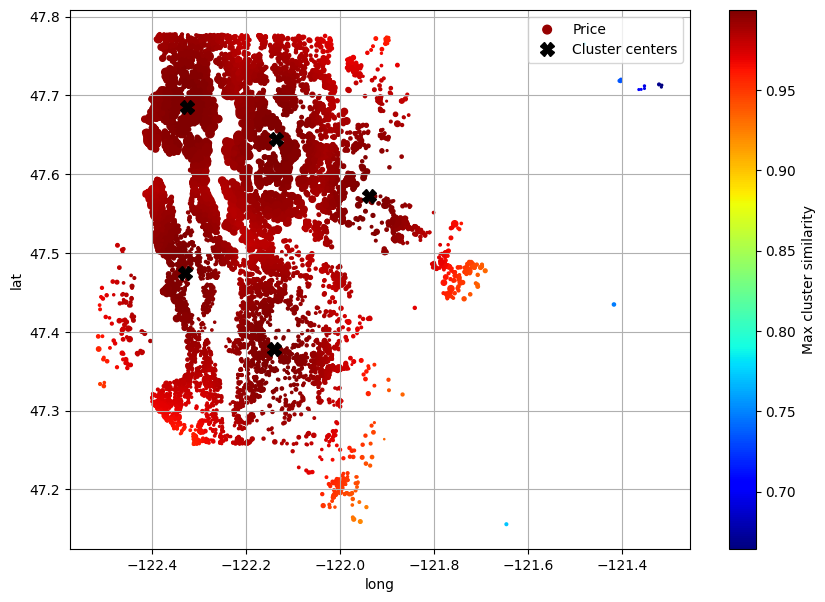

In [44]:
housing_2["Max cluster similarity"] = similarities.max(axis=1)

housing_2.plot(kind="scatter", 
               x="long", 
               y="lat", 
               grid=True,
               s=housing_2["price"] / 100000, 
               label="Price",
               c="Max cluster similarity",
               cmap="jet", 
               colorbar=True,
               legend=True, 
               sharex=False, 
               figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", 
         color="black", 
         marker = "X", 
         markersize=10,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

In [45]:
features_simil = pd.DataFrame(similarities, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 'similar_to_c4', 'similar_to_c5'], 
                              index = housing_2.index)

housing_2 = pd.concat([housing_2, features_simil], axis = 1)

In [46]:
train, cv = train_test_split(housing_2, test_size = 0.25, random_state = 42)

X_tr = train.drop('price', axis = 1)
X_cv = cv.drop('price', axis = 1)

X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)

In [47]:
features_new4 = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
                 'sqft_lot15', 'resale_within_1y?',
                 # one-hot coded binned age features
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50',
                 # one-hot coded zipcodes
                 'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
                 'zipcode_98007', 'zipcode_98008','zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
                 'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
                 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
                 'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
                 'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
                 'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
                 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
                 'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
                 'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
                 'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
                 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
                 'zipcode_98148', 'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 
                 'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199',
                 # location similarities
                 'similar_to_c1', 'similar_to_c2', 'similar_to_c3', 'similar_to_c4', 'similar_to_c5']


model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new4],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new4], y_tr)

pred = model.predict(X_cv[features_new4])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new4], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new4].shape[0], X_cv[features_new4].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 157099.517
RMSE (cv): 178623.888
R2: 0.795
adj. r2: 0.79


In [48]:
data = ['Multiple Linear Regression 5',"location similarity (n_cluster = 5, gamma = 1)", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[5] = data
evaluation

Model  \
0      Simple Linear Regression   
1  Multiple Linear Regression 1   
2  Multiple Linear Regression 2   
3  Multiple Linear Regression 3   
4  Multiple Linear Regression 4   
5  Multiple Linear Regression 5   

                                          Details  RMSE (10 fold)   RMSE (cv)  \
0               "sqft_living" as a single feature      260016.142  274396.995   
1                           all original features      196257.312  219707.748   
2                       added 'resale_within_1y?'      196151.752  219565.571   
3     added 'age_built_binned' & 'age_rnv_binned'      194975.887  218284.442   
4                   treated 'zipcode' as category      157255.411  178766.029   
5  location similarity (n_cluster = 5, gamma = 1)      157099.517  178623.888   

   R-squared (cv) Adj. R-squared  
0           0.515              -  
1           0.689          0.688  
2           0.690          0.689  
3           0.693          0.691  
4           0.794          0.789  
5           0.795           0.79

## 7.7. Multiple Linear Regression (location similarities w/ n_cluster = 21 & gamma = 39) <a id = 7.7></a>
[Return to Table of Contents](#0)

ClusterSimilarity() has 2 parameters we can change: "n_clusters" and "gamma." I am going to use RandomizedSearchCV() to find the best combination of the 2 parameters. 

In [49]:
features = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
            'sqft_lot15', 'resale_within_1y?',
            # one-hot coded binned age features
            'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
            'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
            'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
            'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50',
            # one-hot coded zipcodes
            'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
            'zipcode_98007', 'zipcode_98008','zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
            'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
            'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
            'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
            'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
            'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
            'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
            'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
            'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
            'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
            'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
            'zipcode_98148', 'zipcode_98155', 'zipcode_98166','zipcode_98168', 'zipcode_98177', 
            'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199']

pipeline = Pipeline([
    ('cluster_similarity', ClusterSimilarity()),
    ('regression', LinearRegression())
])

param_dist = {
    'cluster_similarity__n_clusters': randint(2, 30),
    'cluster_similarity__gamma': randint(1, 50)  
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_dist,
    n_iter = 10,
    scoring = 'neg_root_mean_squared_error',
    random_state = 42,
    cv = 5  
)

random_search.fit(X_tr[features], y_tr)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'cluster_similarity__gamma': 39, 'cluster_similarity__n_clusters': 21}


According to the output by RandomizedSearchCV() above, the best combination is 21 clusters with gamma = 39. Let's fit the model with the best parameters and see how the score changes.

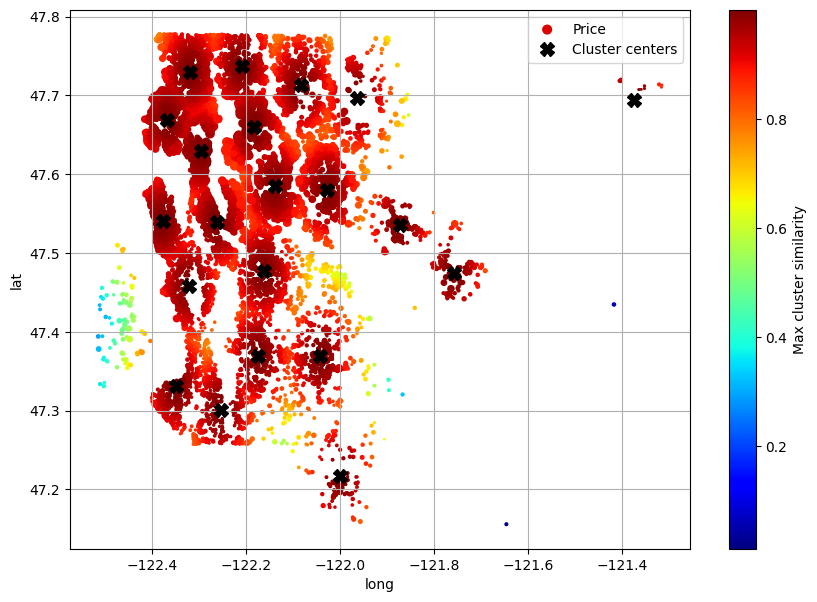

In [50]:
housing_2 = housing.copy()

cluster_simil = ClusterSimilarity(n_clusters=21, gamma=39, random_state=42)
similarities = cluster_simil.fit_transform(housing_2[["lat", "long"]])

housing_2["Max cluster similarity"] = similarities.max(axis=1)

housing_2.plot(kind="scatter", 
               x="long", 
               y="lat", 
               grid=True,
               s=housing_2["price"] / 100000, 
               label="Price",
               c="Max cluster similarity",
               cmap="jet", 
               colorbar=True,
               legend=True, 
               sharex=False, 
               figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", 
         color="black", 
         marker = "X", 
         markersize=10,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

In [51]:
features_simil = pd.DataFrame(similarities, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 
                                                       'similar_to_c4', 'similar_to_c5', 'similar_to_c6', 
                                                       'similar_to_c7', 'similar_to_c8', 'similar_to_c9', 
                                                       'similar_to_c10', 'similar_to_c11', 'similar_to_c12', 
                                                       'similar_to_c13', 'similar_to_c14', 'similar_to_c15',
                                                       'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 
                                                       'similar_to_c19', 'similar_to_c20','similar_to_c21'], 
                              index = housing_2.index)

housing_2 = pd.concat([housing_2, features_simil], axis = 1)

train, cv = train_test_split(housing_2, test_size = 0.25, random_state = 42)

X_tr = train.drop('price', axis = 1)
X_cv = cv.drop('price', axis = 1)

X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)

features_new5 = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
                 'sqft_lot15', 'resale_within_1y?',
                 # one-hot coded binned age columns
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50',
                 # one-hot coded zipcodes
                 'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
                 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
                 'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
                 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
                 'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
                 'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
                 'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
                 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
                 'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
                 'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
                 'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
                 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
                 'zipcode_98148', 'zipcode_98155', 'zipcode_98166','zipcode_98168', 'zipcode_98177', 
                 'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199',
                 # location similarities
                 'similar_to_c1', 'similar_to_c2', 'similar_to_c3', 'similar_to_c4', 'similar_to_c5',
                 'similar_to_c6','similar_to_c7', 'similar_to_c8', 'similar_to_c9', 'similar_to_c10',
                 'similar_to_c11', 'similar_to_c12', 'similar_to_c13', 'similar_to_c14','similar_to_c15',
                 'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 'similar_to_c19', 'similar_to_c20',
                 'similar_to_c21']

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new5],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new5], y_tr)

pred = model.predict(X_cv[features_new5])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new5], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new5].shape[0], X_cv[features_new5].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 155214.029
RMSE (cv): 176872.847
R2: 0.799
adj. r2: 0.793


In [52]:
data = ['Multiple Linear Regression 6',"location similarity (n_cluster = 21, gamma = 39)", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[6] = data
evaluation

Model  \
0      Simple Linear Regression   
1  Multiple Linear Regression 1   
2  Multiple Linear Regression 2   
3  Multiple Linear Regression 3   
4  Multiple Linear Regression 4   
5  Multiple Linear Regression 5   
6  Multiple Linear Regression 6   

                                            Details  RMSE (10 fold)  \
0                 "sqft_living" as a single feature      260016.142   
1                             all original features      196257.312   
2                         added 'resale_within_1y?'      196151.752   
3       added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                     treated 'zipcode' as category      157255.411   
5    location similarity (n_cluster = 5, gamma = 1)      157099.517   
6  location similarity (n_cluster = 21, gamma = 39)      155214.029   

    RMSE (cv)  R-squared (cv) Adj. R-squared  
0  274396.995           0.515              -  
1  219707.748           0.689          0.688  
2  219565.571           0.690          0.689  
3  218284.442           0.693          0.691  
4  178766.029           0.794          0.789  
5  178623.888           0.795           0.79  
6  176872.847           0.799          0.793

## 7.8. Multiple Linear Regression (location similarities w/ n_clusters = 20 & gamma = 40) <a id = 7.8></a>
[Return to Table of Contents](#0)

I am curious to see if the output by RandomizedSearchCV() outperforms other combinations. Since I am going to try multiple parameters, I will create another copy.

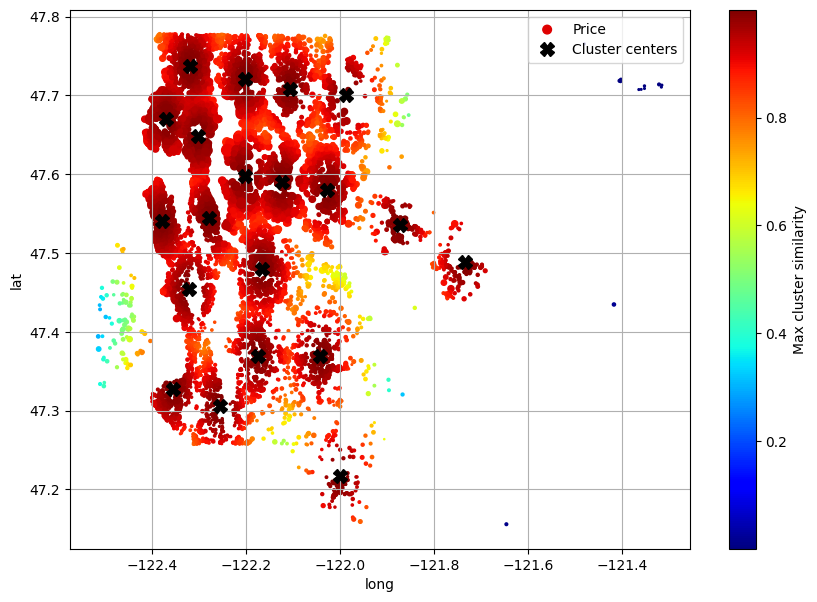

In [53]:
housing_2 = housing.copy()

cluster_simil = ClusterSimilarity(n_clusters=20, gamma=40, random_state=42)
similarities = cluster_simil.fit_transform(housing_2[["lat", "long"]])

housing_2["Max cluster similarity"] = similarities.max(axis=1)

housing_2.plot(kind="scatter", 
               x="long", 
               y="lat", 
               grid=True,
               s=housing_2["price"] / 100000, 
               label="Price",
               c="Max cluster similarity",
               cmap="jet", 
               colorbar=True,
               legend=True, 
               sharex=False, 
               figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", 
         color="black", 
         marker = "X", 
         markersize=10,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

In [54]:
features_simil = pd.DataFrame(similarities, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 
                                                       'similar_to_c4', 'similar_to_c5', 'similar_to_c6', 
                                                       'similar_to_c7', 'similar_to_c8', 'similar_to_c9', 
                                                       'similar_to_c10', 'similar_to_c11', 'similar_to_c12', 
                                                       'similar_to_c13', 'similar_to_c14', 'similar_to_c15',
                                                       'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 
                                                       'similar_to_c19', 'similar_to_c20'], 
                              index = housing_2.index)

housing_2 = pd.concat([housing_2, features_simil], axis = 1)

train, cv = train_test_split(housing_2, test_size = 0.25, random_state = 42)

X_tr = train.drop('price', axis = 1)
X_cv = cv.drop('price', axis = 1)

X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)


features_new6 = ['id','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
                 'sqft_lot15', 'resale_within_1y?',
                 # one-hot coded binned age features
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50',
                 # one-hot coded zipcodes
                 'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
                 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
                 'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
                 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
                 'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
                 'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
                 'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
                 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
                 'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
                 'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
                 'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
                 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
                 'zipcode_98148', 'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 
                 'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199',
                 # location similarities
                 'similar_to_c1', 'similar_to_c2', 'similar_to_c3', 'similar_to_c4', 'similar_to_c5',
                 'similar_to_c6','similar_to_c7', 'similar_to_c8', 'similar_to_c9', 'similar_to_c10',
                 'similar_to_c11', 'similar_to_c12', 'similar_to_c13', 'similar_to_c14','similar_to_c15',
                 'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 'similar_to_c19', 'similar_to_c20']

model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new6],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new6], y_tr)

pred = model.predict(X_cv[features_new6])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new6], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new6].shape[0], X_cv[features_new6].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 155076.784
RMSE (cv): 176847.089
R2: 0.799
adj. r2: 0.794


In [55]:
data = ['Multiple Linear Regression 7',"location similarity (n_cluster = 20, gamma = 40)", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[7] = data
evaluation

Model  \
0      Simple Linear Regression   
1  Multiple Linear Regression 1   
2  Multiple Linear Regression 2   
3  Multiple Linear Regression 3   
4  Multiple Linear Regression 4   
5  Multiple Linear Regression 5   
6  Multiple Linear Regression 6   
7  Multiple Linear Regression 7   

                                            Details  RMSE (10 fold)  \
0                 "sqft_living" as a single feature      260016.142   
1                             all original features      196257.312   
2                         added 'resale_within_1y?'      196151.752   
3       added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                     treated 'zipcode' as category      157255.411   
5    location similarity (n_cluster = 5, gamma = 1)      157099.517   
6  location similarity (n_cluster = 21, gamma = 39)      155214.029   
7  location similarity (n_cluster = 20, gamma = 40)      155076.784   

    RMSE (cv)  R-squared (cv) Adj. R-squared  
0  274396.995           0.515              -  
1  219707.748           0.689          0.688  
2  219565.571           0.690          0.689  
3  218284.442           0.693          0.691  
4  178766.029           0.794          0.789  
5  178623.888           0.795           0.79  
6  176872.847           0.799          0.793  
7  176847.089           0.799          0.794

## 7.9. Multiple Linear Regression (location similarities w/ n_clusters = 20 & gamma = 35) <a id = 7.9></a>
[Return to Table of Contents](#0)

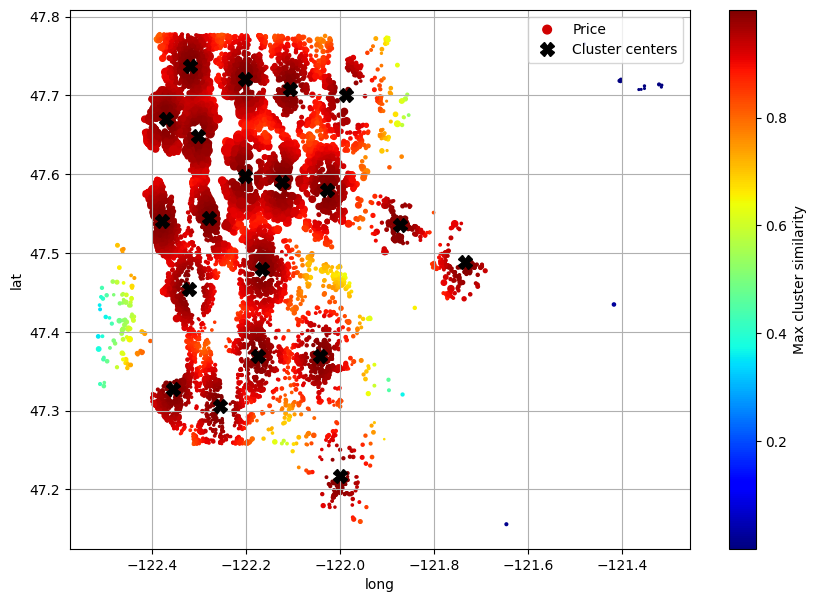

In [56]:
housing_2 = housing.copy()

cluster_simil = ClusterSimilarity(n_clusters=20, gamma=35, random_state=42)
similarities = cluster_simil.fit_transform(housing_2[["lat", "long"]])

housing_2["Max cluster similarity"] = similarities.max(axis=1)

housing_2.plot(kind="scatter", 
               x="long", 
               y="lat", 
               grid=True,
               s=housing_2["price"] / 100000, 
               label="Price",
               c="Max cluster similarity",
               cmap="jet", 
               colorbar=True,
               legend=True, 
               sharex=False, 
               figsize=(10, 7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", 
         color="black", 
         marker = "X", 
         markersize=10,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

In [57]:
features_simil = pd.DataFrame(similarities, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 
                                                       'similar_to_c4', 'similar_to_c5', 'similar_to_c6', 
                                                       'similar_to_c7', 'similar_to_c8', 'similar_to_c9', 
                                                       'similar_to_c10', 'similar_to_c11', 'similar_to_c12', 
                                                       'similar_to_c13', 'similar_to_c14', 'similar_to_c15',
                                                       'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 
                                                       'similar_to_c19', 'similar_to_c20'], 
                              index = housing_2.index)

housing_2 = pd.concat([housing_2, features_simil], axis = 1)

train, cv = train_test_split(housing_2, test_size = 0.25, random_state = 42)

X_tr = train.drop('price', axis = 1)
X_cv = cv.drop('price', axis = 1)

X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)


model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new6],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))


model.fit(X_tr[features_new6], y_tr)

pred = model.predict(X_cv[features_new6])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new6], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new6].shape[0], X_cv[features_new6].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 155164.653
RMSE (cv): 176940.964
R2: 0.798
adj. r2: 0.792


In [58]:
data = ['Multiple Linear Regression 8',"location similarity (n_cluster = 20, gamma = 35)", rmse_10f, rmse, r2, adj_r2]

evaluation.loc[8] = data
evaluation

Model  \
0      Simple Linear Regression   
1  Multiple Linear Regression 1   
2  Multiple Linear Regression 2   
3  Multiple Linear Regression 3   
4  Multiple Linear Regression 4   
5  Multiple Linear Regression 5   
6  Multiple Linear Regression 6   
7  Multiple Linear Regression 7   
8  Multiple Linear Regression 8   

                                            Details  RMSE (10 fold)  \
0                 "sqft_living" as a single feature      260016.142   
1                             all original features      196257.312   
2                         added 'resale_within_1y?'      196151.752   
3       added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                     treated 'zipcode' as category      157255.411   
5    location similarity (n_cluster = 5, gamma = 1)      157099.517   
6  location similarity (n_cluster = 21, gamma = 39)      155214.029   
7  location similarity (n_cluster = 20, gamma = 40)      155076.784   
8  location similarity (n_cluster = 20, gamma = 35)      155164.653   

    RMSE (cv)  R-squared (cv) Adj. R-squared  
0  274396.995           0.515              -  
1  219707.748           0.689          0.688  
2  219565.571           0.690          0.689  
3  218284.442           0.693          0.691  
4  178766.029           0.794          0.789  
5  178623.888           0.795           0.79  
6  176872.847           0.799          0.793  
7  176847.089           0.799          0.794  
8  176940.964           0.798          0.792

The model performed slightly better with 20 clusters with gamma = 40. RandomizedSearchCV did a good job, but since we found better parameters, we will move forward with 20 clusters with gamma = 40.

In [59]:
cluster_simil = ClusterSimilarity(n_clusters=20, gamma=40, random_state=42)

similarities = cluster_simil.fit_transform(housing[["lat", "long"]])
similarities_test = cluster_simil.transform(X_test[["lat", 'long']])

features_simil = pd.DataFrame(similarities, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 
                                                       'similar_to_c4', 'similar_to_c5', 'similar_to_c6', 
                                                       'similar_to_c7', 'similar_to_c8', 'similar_to_c9', 
                                                       'similar_to_c10', 'similar_to_c11', 'similar_to_c12', 
                                                       'similar_to_c13', 'similar_to_c14', 'similar_to_c15',
                                                       'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 
                                                       'similar_to_c19', 'similar_to_c20'], 
                              index = housing.index)

features_simil_test = pd.DataFrame(similarities_test, columns = ['similar_to_c1', 'similar_to_c2', 'similar_to_c3', 
                                                                 'similar_to_c4', 'similar_to_c5', 'similar_to_c6', 
                                                                 'similar_to_c7', 'similar_to_c8', 'similar_to_c9', 
                                                                 'similar_to_c10','similar_to_c11', 'similar_to_c12', 
                                                                 'similar_to_c13', 'similar_to_c14', 'similar_to_c15',
                                                                 'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 
                                                                 'similar_to_c19', 'similar_to_c20'], 
                              index = X_test.index)

housing = pd.concat([housing, features_simil], axis = 1)
X_test = pd.concat([X_test, features_simil_test], axis = 1)

train, cv = train_test_split(housing, test_size = 0.25, random_state = 42)

X_tr = train.drop('price', axis = 1)
X_cv = cv.drop('price', axis = 1)

X_tr = pd.get_dummies(X_tr, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_cv = pd.get_dummies(X_cv, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)
X_test = pd.get_dummies(X_test, columns = ['age_built_binned', 'age_rnv_binned', 'zipcode'], dtype = 'int', drop_first = True)

## 7.10. Multiple Linear Regression (root squared) <a id = 7.10></a>
[Return to Table of Contents](#0)

Earlier, we found that the relationship between "sqft" related features and "price" showed heteroscedasticity. We also saw that the transformed "sqft-living" and "price" showed a linear relationship. Let's apply those transformations. I will start with "sqft" related variables. 

In [60]:
X_tr = X_tr.assign(
        sqft_living_sqrt = np.sqrt(X_tr['sqft_living']),
        sqft_above_sqrt = np.sqrt(X_tr['sqft_above']),
        sqft_living15_sqrt = np.sqrt(X_tr['sqft_living15'])
    )

X_cv = X_cv.assign(
        sqft_living_sqrt = np.sqrt(X_cv['sqft_living']),
        sqft_above_sqrt = np.sqrt(X_cv['sqft_above']),
        sqft_living15_sqrt = np.sqrt(X_cv['sqft_living15'])
    )

X_test = X_test.assign(
        sqft_living_sqrt = np.sqrt(X_test['sqft_living']),
        sqft_above_sqrt = np.sqrt(X_test['sqft_above']),
        sqft_living15_sqrt = np.sqrt(X_test['sqft_living15'])
    )

In [61]:
features_new7 = ['id','bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 
                 'condition', 'grade', 'sqft_basement', 'sqft_lot15', 'resale_within_1y?', 
                 'sqft_living', 'sqft_above', 'sqft_living15', 
                 # one-hot coded binned age features
                 'age_built_binned_1-5','age_built_binned_6-10', 'age_built_binned_11-25', 
                 'age_built_binned_26-50', 'age_built_binned_51-75', 'age_built_binned_76-100', 
                 'age_built_binned_>100', 'age_rnv_binned_0-5', 'age_rnv_binned_6-15', 
                 'age_rnv_binned_16-30', 'age_rnv_binned_31-50', 'age_rnv_binned_>50',
                 # one-hot coded zipcodes 27
                 'zipcode_98002', 'zipcode_98003', 'zipcode_98004','zipcode_98005', 'zipcode_98006', 
                 'zipcode_98007', 'zipcode_98008','zipcode_98010', 'zipcode_98011', 'zipcode_98014', 
                 'zipcode_98019','zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
                 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031','zipcode_98032', 
                 'zipcode_98033', 'zipcode_98034', 'zipcode_98038','zipcode_98039', 'zipcode_98040', 
                 'zipcode_98042', 'zipcode_98045','zipcode_98052', 'zipcode_98053', 'zipcode_98055', 
                 'zipcode_98056','zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
                 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077','zipcode_98092', 
                 'zipcode_98102', 'zipcode_98103', 'zipcode_98105','zipcode_98106', 'zipcode_98107', 
                 'zipcode_98108', 'zipcode_98109','zipcode_98112', 'zipcode_98115', 'zipcode_98116', 
                 'zipcode_98117','zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 
                 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144','zipcode_98146', 
                 'zipcode_98148', 'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 
                 'zipcode_98178', 'zipcode_98188','zipcode_98198', 'zipcode_98199',
                 # location similarities
                 'similar_to_c1', 'similar_to_c2', 'similar_to_c3', 'similar_to_c4', 'similar_to_c5',
                 'similar_to_c6','similar_to_c7', 'similar_to_c8', 'similar_to_c9', 'similar_to_c10',
                 'similar_to_c11', 'similar_to_c12', 'similar_to_c13', 'similar_to_c14','similar_to_c15',
                 'similar_to_c16', 'similar_to_c17', 'similar_to_c18', 'similar_to_c19', 'similar_to_c20',
                 # square root
                 'sqft_living_sqrt', 'sqft_above_sqrt', 'sqft_living15_sqrt']


model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new7],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new7], y_tr)

pred = model.predict(X_cv[features_new7])

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new7], y_cv), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new7].shape[0], X_cv[features_new7].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 149283.347
RMSE (cv): 164618.8
R2: 0.826
adj. r2: 0.821


In [62]:
data = ['Multiple Linear Regression 9','applied square root transform', rmse_10f, rmse , r2, adj_r2]

evaluation.loc[9] = data
evaluation

Model  \
0      Simple Linear Regression   
1  Multiple Linear Regression 1   
2  Multiple Linear Regression 2   
3  Multiple Linear Regression 3   
4  Multiple Linear Regression 4   
5  Multiple Linear Regression 5   
6  Multiple Linear Regression 6   
7  Multiple Linear Regression 7   
8  Multiple Linear Regression 8   
9  Multiple Linear Regression 9   

                                            Details  RMSE (10 fold)  \
0                 "sqft_living" as a single feature      260016.142   
1                             all original features      196257.312   
2                         added 'resale_within_1y?'      196151.752   
3       added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                     treated 'zipcode' as category      157255.411   
5    location similarity (n_cluster = 5, gamma = 1)      157099.517   
6  location similarity (n_cluster = 21, gamma = 39)      155214.029   
7  location similarity (n_cluster = 20, gamma = 40)      155076.784   
8  location similarity (n_cluster = 20, gamma = 35)      155164.653   
9                     applied square root transform      149283.347   

    RMSE (cv)  R-squared (cv) Adj. R-squared  
0  274396.995           0.515              -  
1  219707.748           0.689          0.688  
2  219565.571           0.690          0.689  
3  218284.442           0.693          0.691  
4  178766.029           0.794          0.789  
5  178623.888           0.795           0.79  
6  176872.847           0.799          0.793  
7  176847.089           0.799          0.794  
8  176940.964           0.798          0.792  
9  164618.800           0.826          0.821

## 7.11. Multiple Linear Regression (log-transformed a target variable) <a id = 7.11></a>
[Return to Table of Contents](#0)

Let's also transofrm a target variable "price."

In [63]:
y_tr_log = np.log(y_tr).T
y_cv_log = np.log(y_cv).T
y_test_log = np.log(y_test).T

In [64]:
model = LinearRegression()

rmse_10f = float(format(-cross_val_score(model,
                                         X_tr[features_new7],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

model.fit(X_tr[features_new7], y_tr_log)

pred_log = model.predict(X_cv[features_new7])
pred = np.exp(pred_log)

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new7], y_cv_log), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new7].shape[0], X_cv[features_new7].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 149283.347
RMSE (cv): 134934.547
R2: 0.898
adj. r2: 0.895


In [65]:
data = ['Multiple Linear Regression 10',"log-transformed a target variable", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[10] = data
evaluation

Model  \
0        Simple Linear Regression   
1    Multiple Linear Regression 1   
2    Multiple Linear Regression 2   
3    Multiple Linear Regression 3   
4    Multiple Linear Regression 4   
5    Multiple Linear Regression 5   
6    Multiple Linear Regression 6   
7    Multiple Linear Regression 7   
8    Multiple Linear Regression 8   
9    Multiple Linear Regression 9   
10  Multiple Linear Regression 10   

                                             Details  RMSE (10 fold)  \
0                  "sqft_living" as a single feature      260016.142   
1                              all original features      196257.312   
2                          added 'resale_within_1y?'      196151.752   
3        added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                      treated 'zipcode' as category      157255.411   
5     location similarity (n_cluster = 5, gamma = 1)      157099.517   
6   location similarity (n_cluster = 21, gamma = 39)      155214.029   
7   location similarity (n_cluster = 20, gamma = 40)      155076.784   
8   location similarity (n_cluster = 20, gamma = 35)      155164.653   
9                      applied square root transform      149283.347   
10                 log-transformed a target variable      149283.347   

     RMSE (cv)  R-squared (cv) Adj. R-squared  
0   274396.995           0.515              -  
1   219707.748           0.689          0.688  
2   219565.571           0.690          0.689  
3   218284.442           0.693          0.691  
4   178766.029           0.794          0.789  
5   178623.888           0.795           0.79  
6   176872.847           0.799          0.793  
7   176847.089           0.799          0.794  
8   176940.964           0.798          0.792  
9   164618.800           0.826          0.821  
10  134934.547           0.898          0.895

It is clear that these transformations helped the model improve predictive accuracy!

## 7.12. Ridge Regression <a id = 7.12></a>
[Return to Table of Contents](#0)

It is usually better to have some sort of regulalization in the model. The popular choice is a Ridge regression and Lasso regression. Let's try both. I will start with the Ridge regression. 

I am going to use RidgeCV() to find the best alpha value.

In [66]:
n_alpha = 200
alphas = 10 ** np.linspace(-3, 3, n_alpha)

pipeline = Pipeline([
    ('scaler', StandardScaler()),      
    ('ridge_cv', RidgeCV(alphas=alphas, cv = 5))
])

pipeline.fit(X_tr[features_new7], y_tr_log)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge_cv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.07189132e-03, 1.14895100e-03, 1.23155060e-03,
       1.32008840e-03, 1.41499130e-03, 1.51671689e-03, 1.62575567e-03,
       1.74263339e-03, 1.86791360e-03, 2.00220037e-03, 2.14614120e-03,
       2.30043012e-03, 2.46581108e-03, 2.64308149e-03, 2.83309610e-03,
       3.03677112e-03, 3.25508860e-03, 3....
       2.02550194e+02, 2.17111795e+02, 2.32720248e+02, 2.49450814e+02,
       2.67384162e+02, 2.86606762e+02, 3.07211300e+02, 3.29297126e+02,
       3.52970730e+02, 3.78346262e+02, 4.05546074e+02, 4.34701316e+02,
       4.65952567e+02, 4.99450512e+02, 5.35356668e+02, 5.73844165e+02,
       6.15098579e+02, 6.59318827e+02, 7.06718127e+02, 7.57525026e+02,
       8.11984499e+02, 8.70359136e+02, 9.32930403e+02, 1.00000000e+03]),
                         cv=5))])

In [67]:
best_alpha_ridge = pipeline.named_steps['ridge_cv'].alpha_

print(best_alpha_ridge)

0.05607169938205458


In [68]:
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha = best_alpha_ridge))

rmse_10f = float(format(-cross_val_score(ridge_model,
                                         X_tr[features_new7],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

ridge_model.fit(X_tr[features_new7], y_tr_log)

pred_log = ridge_model.predict(X_cv[features_new7])
pred = np.exp(pred_log)

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new7], y_cv_log), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new7].shape[0], X_cv[features_new7].shape[1]), '.3f'))


print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 149280.741
RMSE (cv): 134926.802
R2: 0.898
adj. r2: 0.895


In [69]:
data = ['Ridge Regression',"alpha = 0.056", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[11] = data
evaluation

Model  \
0        Simple Linear Regression   
1    Multiple Linear Regression 1   
2    Multiple Linear Regression 2   
3    Multiple Linear Regression 3   
4    Multiple Linear Regression 4   
5    Multiple Linear Regression 5   
6    Multiple Linear Regression 6   
7    Multiple Linear Regression 7   
8    Multiple Linear Regression 8   
9    Multiple Linear Regression 9   
10  Multiple Linear Regression 10   
11               Ridge Regression   

                                             Details  RMSE (10 fold)  \
0                  "sqft_living" as a single feature      260016.142   
1                              all original features      196257.312   
2                          added 'resale_within_1y?'      196151.752   
3        added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                      treated 'zipcode' as category      157255.411   
5     location similarity (n_cluster = 5, gamma = 1)      157099.517   
6   location similarity (n_cluster = 21, gamma = 39)      155214.029   
7   location similarity (n_cluster = 20, gamma = 40)      155076.784   
8   location similarity (n_cluster = 20, gamma = 35)      155164.653   
9                      applied square root transform      149283.347   
10                 log-transformed a target variable      149283.347   
11                                     alpha = 0.056      149280.741   

     RMSE (cv)  R-squared (cv) Adj. R-squared  
0   274396.995           0.515              -  
1   219707.748           0.689          0.688  
2   219565.571           0.690          0.689  
3   218284.442           0.693          0.691  
4   178766.029           0.794          0.789  
5   178623.888           0.795           0.79  
6   176872.847           0.799          0.793  
7   176847.089           0.799          0.794  
8   176940.964           0.798          0.792  
9   164618.800           0.826          0.821  
10  134934.547           0.898          0.895  
11  134926.802           0.898          0.895

## 7.13. Lasso Regression <a id = 7.13></a>
[Return to Table of Contents](#0)

In [70]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),   
    ('lasso_cv', LassoCV(alphas=alphas, cv = 5)) 
])

pipeline.fit(X_tr[features_new7], y_tr_log)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso_cv',
                 LassoCV(alphas=array([1.00000000e-03, 1.07189132e-03, 1.14895100e-03, 1.23155060e-03,
       1.32008840e-03, 1.41499130e-03, 1.51671689e-03, 1.62575567e-03,
       1.74263339e-03, 1.86791360e-03, 2.00220037e-03, 2.14614120e-03,
       2.30043012e-03, 2.46581108e-03, 2.64308149e-03, 2.83309610e-03,
       3.03677112e-03, 3.25508860e-03, 3....
       2.02550194e+02, 2.17111795e+02, 2.32720248e+02, 2.49450814e+02,
       2.67384162e+02, 2.86606762e+02, 3.07211300e+02, 3.29297126e+02,
       3.52970730e+02, 3.78346262e+02, 4.05546074e+02, 4.34701316e+02,
       4.65952567e+02, 4.99450512e+02, 5.35356668e+02, 5.73844165e+02,
       6.15098579e+02, 6.59318827e+02, 7.06718127e+02, 7.57525026e+02,
       8.11984499e+02, 8.70359136e+02, 9.32930403e+02, 1.00000000e+03]),
                         cv=5))])

In [71]:
best_alpha_lasso = pipeline.named_steps['lasso_cv'].alpha_

print(best_alpha_lasso)

0.001


In [72]:
lasso_model = make_pipeline(StandardScaler(), Lasso(alpha = best_alpha_lasso))

warnings.filterwarnings("ignore", category=ConvergenceWarning)

rmse_10f = float(format(-cross_val_score(lasso_model,
                                         X_tr[features_new7],
                                         y_tr,
                                         cv=10, 
                                         scoring = 'neg_root_mean_squared_error').mean(),
                        '.3f'))

lasso_model.fit(X_tr[features_new7], y_tr_log)

pred_log = lasso_model.predict(X_cv[features_new7])
pred = np.exp(pred_log)

rmse = float(format(mse(y_cv, pred, squared = False), '.3f'))

r2 =  float(format(model.score(X_cv[features_new7], y_cv_log), '.3f'))

adj_r2 = float(format(adjustedR2(r2, X_cv[features_new7].shape[0], X_cv[features_new7].shape[1]), '.3f'))

print(f'RMSE (10 fold): {rmse_10f}')
print(f'RMSE (cv): {rmse}')
print(f'R2: {r2}')
print(f'adj. r2: {adj_r2}')

RMSE (10 fold): 149410.179
RMSE (cv): 135711.575
R2: 0.898
adj. r2: 0.895


In [73]:
data = ['Lasso Regression',"alpha = 0.01", rmse_10f, rmse , r2, adj_r2]

evaluation.loc[12] = data
evaluation

Model  \
0        Simple Linear Regression   
1    Multiple Linear Regression 1   
2    Multiple Linear Regression 2   
3    Multiple Linear Regression 3   
4    Multiple Linear Regression 4   
5    Multiple Linear Regression 5   
6    Multiple Linear Regression 6   
7    Multiple Linear Regression 7   
8    Multiple Linear Regression 8   
9    Multiple Linear Regression 9   
10  Multiple Linear Regression 10   
11               Ridge Regression   
12               Lasso Regression   

                                             Details  RMSE (10 fold)  \
0                  "sqft_living" as a single feature      260016.142   
1                              all original features      196257.312   
2                          added 'resale_within_1y?'      196151.752   
3        added 'age_built_binned' & 'age_rnv_binned'      194975.887   
4                      treated 'zipcode' as category      157255.411   
5     location similarity (n_cluster = 5, gamma = 1)      157099.517   
6   location similarity (n_cluster = 21, gamma = 39)      155214.029   
7   location similarity (n_cluster = 20, gamma = 40)      155076.784   
8   location similarity (n_cluster = 20, gamma = 35)      155164.653   
9                      applied square root transform      149283.347   
10                 log-transformed a target variable      149283.347   
11                                     alpha = 0.056      149280.741   
12                                      alpha = 0.01      149410.179   

     RMSE (cv)  R-squared (cv) Adj. R-squared  
0   274396.995           0.515              -  
1   219707.748           0.689          0.688  
2   219565.571           0.690          0.689  
3   218284.442           0.693          0.691  
4   178766.029           0.794          0.789  
5   178623.888           0.795           0.79  
6   176872.847           0.799          0.793  
7   176847.089           0.799          0.794  
8   176940.964           0.798          0.792  
9   164618.800           0.826          0.821  
10  134934.547           0.898          0.895  
11  134926.802           0.898          0.895  
12  135711.575           0.898          0.895

# 8. Choose a Model <a id = 8></a>
[Return to Table of Contents](#0)

I am going to choose the model with the lowest RMSE (10 cv). Let's sort the evaluation by RMSE.

In [74]:
evaluation.sort_values(by = 'RMSE (cv)', ascending = True)

Model  \
11               Ridge Regression   
10  Multiple Linear Regression 10   
12               Lasso Regression   
9    Multiple Linear Regression 9   
7    Multiple Linear Regression 7   
6    Multiple Linear Regression 6   
8    Multiple Linear Regression 8   
5    Multiple Linear Regression 5   
4    Multiple Linear Regression 4   
3    Multiple Linear Regression 3   
2    Multiple Linear Regression 2   
1    Multiple Linear Regression 1   
0        Simple Linear Regression   

                                             Details  RMSE (10 fold)  \
11                                     alpha = 0.056      149280.741   
10                 log-transformed a target variable      149283.347   
12                                      alpha = 0.01      149410.179   
9                      applied square root transform      149283.347   
7   location similarity (n_cluster = 20, gamma = 40)      155076.784   
6   location similarity (n_cluster = 21, gamma = 39)      155214.029   
8   location similarity (n_cluster = 20, gamma = 35)      155164.653   
5     location similarity (n_cluster = 5, gamma = 1)      157099.517   
4                      treated 'zipcode' as category      157255.411   
3        added 'age_built_binned' & 'age_rnv_binned'      194975.887   
2                          added 'resale_within_1y?'      196151.752   
1                              all original features      196257.312   
0                  "sqft_living" as a single feature      260016.142   

     RMSE (cv)  R-squared (cv) Adj. R-squared  
11  134926.802           0.898          0.895  
10  134934.547           0.898          0.895  
12  135711.575           0.898          0.895  
9   164618.800           0.826          0.821  
7   176847.089           0.799          0.794  
6   176872.847           0.799          0.793  
8   176940.964           0.798          0.792  
5   178623.888           0.795           0.79  
4   178766.029           0.794          0.789  
3   218284.442           0.693          0.691  
2   219565.571           0.690          0.689  
1   219707.748           0.689          0.688  
0   274396.995           0.515              -

The best performing model was Ridge Regression!

# 9. Evaluate a Model with Test Set <a id = 9></a>
[Return to Table of Contents](#0)

Finally! Let's evaluate the test set using our Ridge Regression model and see how it does with unseen data.

In [75]:
pred_log = ridge_model.predict(X_test[features_new7])
pred = np.exp(pred_log)

mse_test = float(format(mse(y_test, pred, squared = False), '.3f'))
r2_test = float(format(ridge_model.score(X_test[features_new7], y_test_log), '.3f'))
adj_r2_test = float(format(adjustedR2(r2_test, X_test[features_new7].shape[0], X_test[features_new7].shape[1]), '.3f'))

print(f'RMSE (test): {mse_test}')
print(f'R2 (test): {r2_test}')
print(f'Adj. R2 (test): {adj_r2_test}')

RMSE (test): 113084.914
R2 (test): 0.887
Adj. R2 (test): 0.884


Great! The model performed even better with the test data! 

# 10. Build a Full-Pipeline <a id = 10></a>
[Return to Table of Contents](#0)

Through the kernel, I transformed the test data set manually, but it is better to build a full-pipeline so we can reproduce these transformations easily on any dataset.

In [76]:
num_features = ['id','bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 
                'condition', 'grade', 'sqft_basement', 'sqft_lot15', 'sqft_living', 
                'sqft_above', 'sqft_living15']

num_pipeline = Pipeline([
    ('standardize', StandardScaler())
])

def create_resale_within_1y(X):
    return np.where(X.groupby('id')['date'].diff() <= pd.Timedelta(days=365), 1, 0).reshape(-1, 1)

def resale_within_1y_name(function_transformer, feature_names_in):
    return ['resale_within_1y?']

def create_age_built_binned(X):
    X['age_built'] = (X['date'].astype('string').str[:4].astype(int) - X['yr_built'])
    return np.array(pd.cut(X['age_built'], bins=[-2, 0, 5, 10, 25, 50, 75, 100, np.inf], labels=['<1', '1-5', '6-10', '11-25', '26-50', '51-75', '76-100', '>100'])).reshape(-1, 1)

def age_built_binned_name(function_transformer, feature_names_in):
    return ['age_built_binned']

def create_age_rnv_binned(X):
    X['age_rnv'] = (X['date'].astype('string').str[:4].astype(int) - X['yr_renovated'])
    return np.array(pd.cut(X['age_rnv'], bins=[-2, -1, 5, 15, 30, 50, np.inf], labels=['-1', '0-5', '6-15', '16-30', '31-50', '>50'])).reshape(-1, 1)

def age_rnv_binned_name(function_transformer, feature_names_in):
    return ['age_rnv_binned']

def resale_pipeline():
    return make_pipeline(
        FunctionTransformer(create_resale_within_1y, feature_names_out = 'one-to-one'),
        StandardScaler()
        )

def age_built_binned_pipeline():
    return make_pipeline(
        FunctionTransformer(create_age_built_binned, feature_names_out = 'one-to-one'),
        OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
        )

def age_rnv_binned_pipeline():
    return make_pipeline(
        FunctionTransformer(create_age_rnv_binned, feature_names_out = 'one-to-one'),
        OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
        )

cluster_simil = ClusterSimilarity(n_clusters=20, gamma=40, random_state=42)

sqrt_pipeline = make_pipeline(
    FunctionTransformer(np.sqrt, feature_names_out = 'one-to-one'),
    StandardScaler())


preprocessing = ColumnTransformer([
    ('num_features', num_pipeline, num_features),
    ('resale_within_1y', resale_pipeline(), ['id', 'date']),
    ('age_built_binned', age_built_binned_pipeline(), ['date', 'yr_built']),
    ('age_rnv_binned', age_rnv_binned_pipeline(), ['date', 'yr_renovated']),
    ('geo', cluster_simil, ['lat', 'long']),
    ('categorical', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), ['zipcode']),
    ('sqrt', sqrt_pipeline, ['sqft_living', 'sqft_above', 'sqft_living15'])
]
)

final_model = make_pipeline(
                    preprocessing,
                    Ridge(alpha = 0.05607169938205458)
)


# 11. Final Result <a id = 11></a>
[Return to Table of Contents](#0)

Now, let's use the entire training set to fit to the model and use the test set to produce the final result.

In [77]:
X_train = strat_tr.drop('price', axis = 1)
y_train = strat_tr['price']
y_train_log = np.log(y_train)

X_test = strat_test.drop('price', axis = 1)
y_test = strat_test['price']
y_test_log = np.log(y_test)

In [78]:
final_model.fit(X_train, y_train_log)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['id', 'bedrooms',
                                                   'bathrooms', 'sqft_lot',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'sqft_basement',
                                                   'sqft_lot15', 'sqft_living',
                                                   'sqft_above',
                                                   'sqft_living15']),
                                                 ('resale_within_1y',
                                                  Pipeline(steps=[('functiontrans...
                                                                    random_state=42),
                                                  ['lat', 'long']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['zipcode']),
                                                 ('sqrt',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'sqrt'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['sqft_living', 'sqft_above',
                                                   'sqft_living15'])])),
                ('ridge', Ridge(alpha=0.05607169938205458))])

In [79]:
pred_log = final_model.predict(X_test)
pred = np.exp(pred_log)

mse_final = float(format(mse(y_test, pred, squared = False), '.3f'))
r2_final = float(format(final_model.score(X_test, y_test_log), '.3f'))
adj_r2_final = float(format(adjustedR2(r2_final, X_test.shape[0], X_test.shape[1]), '.3f'))

print(f'RMSE (test): {mse_final}')
print(f'R2 (test): {r2_final}')
print(f'Adj. R2 (test): {adj_r2_final}')

RMSE (test): 112891.256
R2 (test): 0.887
Adj. R2 (test): 0.886


In [80]:
final_result = pd.DataFrame({'Selected Model': ['Ridge Regression'],
                           'Details':['alpha = 0.056'],
                           'RMSE (test)': [mse_final],
                           'R-squared (test)':[r2_final],
                           'Adj. R-squared (test)':[adj_r2_final]}
                         )

In [81]:
final_result

Selected Model        Details  RMSE (test)  R-squared (test)  \
0  Ridge Regression  alpha = 0.056   112891.256             0.887   

   Adj. R-squared (test)  
0                  0.886

# 12. Conclusion <a id = 12></a>
[Return to Table of Contents](#0)

Thank you very much for reading my kernel. Please note that while I only used the single linear regression, the multiple linear regression, and the regularized linear regression in this kernel, there are other options for possible models, like a decision tree. If you liked this kernel, __please upvote__, and any __feedback/comment__ is much appreciated!

Best,                  
Seiji